# Melbourne Housing Price

참고: https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html#:~:text=%EB%8B%A4%EC%A4%91%20%EA%B3%B5%EC%84%A0%EC%84%B1%EC%9D%84%20%EC%97%86%EC%95%A0%EB%8A%94,%ED%95%9C%20%EC%84%B1%EB%8A%A5%EC%9D%84%20%EB%82%98%ED%83%80%EB%82%B8%20%EA%B2%83%EC%9D%B4%EB%8B%A4.

https://hleecaster.com/ml-multiple-linear-regression-example/

In [308]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.datasets.longley import load_pandas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [2]:
#피클 다시 불러오기
import pickle
df = pd.read_pickle("Melbourne_processed.pickle")

# 1. EDA 및 Feature Engineering 진행하기

In [195]:
df = pd.read_csv('melb_data.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


## 1-1. 결측치 확인 및 처리


In [4]:
#결측치 확인
df.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [4]:
#데이터의 개수는 총 13580개 이다.
len(df)

13580

<AxesSubplot:>

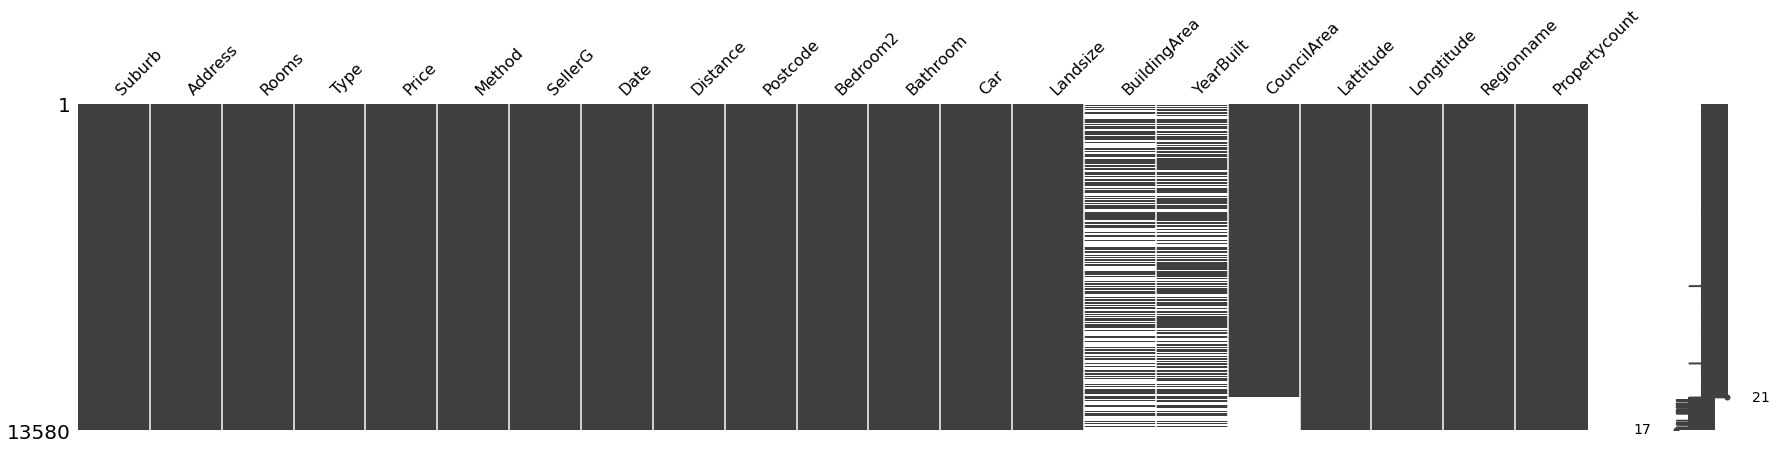

In [6]:
#missingno 함수를 사용하여 결측치 분포 확인
import missingno as msno
msno.matrix(df, figsize=(30,6))

Missing No에서 확인해본 결과, 결측치가 존재하는 column은 
- Car, 
- Building Area, 
- Year Built, 
- Council Area 4개가 확인된다. 

Melbourne데이터셋의 경우 13580개의 데이터가 있어 크게 걱정할 수준은 아닐것으로 생각되나, Building Area의 경우 결측치가 전체 데이터의 절반에 해당하는 약 6000개정도가 존재하여, 이 부분을 채우는 것이 좋아보인다.


- Car: 주차장 수, 62
- Building Area: 건물의 크기, 6450
- Year Built: 건축 날짜, 5375
- Council Area: 지역 행정구역, 1369

- 결측치를 채우기 위해 Domain Knowledge를 사용하여 생각해보면, 주차장 수는 결측치 수가 적고, 다른 특성을 사용하여 유추하기 힘들기때문에 결측치를 삭제하기로 결정하였다. 
- Building Area의 경우 Landsize와 비교했을때 비슷한 특성을 가질것이라 생각했고, 만약 Landsize와의 선형 관계가 있는 독립변수를 추가한다면 다중공선성을 야기할수 있기 때문에 컬럼 전체를 삭제 하기로 결정하였다. 
- Year Built의 경우에도 다른 정보를 통해 건축 날짜를 알 수 없어 결측치만 삭제하기로 결정하였다.
- Council Area의 경우 대부분 Council Area를 공유하는 경우에는 Postcode가 같기 때문에, 같은 PostCode를 가지는 데이터에 대해서 같은 Council Area를 부여하도록 하였다.

In [196]:
df_2 = df.drop(labels =['BuildingArea'], axis=1, errors='ignore') #결측치가 존재하는 행 영구 삭제
df_2.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [197]:
#Car column에 존재하는 결측치 삭제
df_2 = df_2.dropna(subset=['Car'])
len(df_2)
#62개가 삭제되어 (13580 - 62 = 13518) 13518개인것을 확인 할 수 있다.

13518

In [198]:
#yearbuilt column에 존재하는 결측치 삭제
df_2 = df_2.dropna(subset=['YearBuilt'])
len(df_2)

8174

In [199]:
df_2 = df_2.sort_values('Postcode')
df_2.head(30)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
3983,Melbourne,1615/250 Elizabeth St,1,u,386000.0,S,Dingle,10/09/2016,2.8,3000.0,1.0,1.0,0.0,0.0,1976.0,Melbourne,-37.8127,144.9627,Northern Metropolitan,17496.0
4005,Melbourne,1003/265 Exhibition St,3,u,760000.0,S,hockingstuart,28/05/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,Melbourne,-37.8095,144.9691,Northern Metropolitan,17496.0
4003,Melbourne,702/108 Flinders St,2,u,675000.0,VB,Kay,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,2014.0,Melbourne,-37.8161,144.9712,Northern Metropolitan,17496.0
4002,Melbourne,507/325 Collins St,2,u,733000.0,S,MICM,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1965.0,Melbourne,-37.8166,144.9635,Northern Metropolitan,17496.0
4000,Melbourne,303/166 Flinders St,1,u,440000.0,S,Harcourts,22/08/2016,2.8,3000.0,1.0,1.0,1.0,0.0,1920.0,Melbourne,-37.8168,144.9691,Northern Metropolitan,17496.0
3998,Melbourne,32/2 Exhibition St,1,u,700000.0,VB,Castran,19/11/2016,2.8,3000.0,1.0,1.0,1.0,0.0,1920.0,Melbourne,-37.8157,144.9727,Northern Metropolitan,17496.0
3996,Melbourne,715/300 Swanston St,2,u,483000.0,S,Greg,18/03/2017,2.8,3000.0,1.0,1.0,1.0,0.0,2004.0,Melbourne,-37.8106,144.9646,Northern Metropolitan,17496.0
3994,Melbourne,1001/639 Little Bourke St,2,u,470000.0,VB,Greg,18/03/2017,2.8,3000.0,2.0,1.0,2.0,0.0,1917.0,Melbourne,-37.8160,144.9535,Northern Metropolitan,17496.0
3993,Melbourne,33/300 King St,1,u,680000.0,S,MICM,17/09/2016,2.8,3000.0,1.0,1.0,2.0,0.0,1965.0,Melbourne,-37.8132,144.9545,Northern Metropolitan,17496.0
3992,Melbourne,208/108 Flinders St,1,u,375000.0,PI,LITTLE,15/10/2016,2.8,3000.0,1.0,1.0,0.0,1414.0,2014.0,Melbourne,-37.8161,144.9712,Northern Metropolitan,17496.0


In [ ]:
#인접한 Postcode는 같은 CouncilArea를 가지고 있기때문에 postcode 순으로 sort하고 ffill을 사용하기

In [200]:
df_2['CouncilArea'] = df_2['CouncilArea'].fillna(method='ffill')
df_2

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
3983,Melbourne,1615/250 Elizabeth St,1,u,386000.0,S,Dingle,10/09/2016,2.8,3000.0,1.0,1.0,0.0,0.0,1976.0,Melbourne,-37.81270,144.96270,Northern Metropolitan,17496.0
4005,Melbourne,1003/265 Exhibition St,3,u,760000.0,S,hockingstuart,28/05/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,Melbourne,-37.80950,144.96910,Northern Metropolitan,17496.0
4003,Melbourne,702/108 Flinders St,2,u,675000.0,VB,Kay,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,2014.0,Melbourne,-37.81610,144.97120,Northern Metropolitan,17496.0
4002,Melbourne,507/325 Collins St,2,u,733000.0,S,MICM,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1965.0,Melbourne,-37.81660,144.96350,Northern Metropolitan,17496.0
4000,Melbourne,303/166 Flinders St,1,u,440000.0,S,Harcourts,22/08/2016,2.8,3000.0,1.0,1.0,1.0,0.0,1920.0,Melbourne,-37.81680,144.96910,Northern Metropolitan,17496.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13446,Hampton Park,4 Somerville Rd,4,h,625000.0,S,Rexhepi,26/08/2017,33.3,3976.0,4.0,1.0,2.0,640.0,1960.0,Casey,-38.02981,145.24826,South-Eastern Metropolitan,8256.0
11960,Cranbourne North,13 Cumquat Ct,4,h,500000.0,S,Ray,29/07/2017,34.7,3977.0,4.0,2.0,0.0,579.0,1990.0,Casey,-38.07202,145.27369,South-Eastern Metropolitan,6464.0
10039,Sandhurst,4 Galilee Dr,4,h,645000.0,SP,Harcourts,24/06/2017,34.7,3977.0,4.0,2.0,2.0,448.0,2010.0,Frankston,-38.08170,145.19654,South-Eastern Metropolitan,1721.0
13404,Cranbourne,48 Majestic Bvd,5,h,720008.0,SP,O'Brien,26/08/2017,34.7,3977.0,5.0,3.0,2.0,528.0,2006.0,Frankston,-38.08902,145.29006,South-Eastern Metropolitan,7680.0


In [201]:
df_2.isnull().sum()
#null값이 모두 채워진것을 알 수 있다.

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

In [39]:
len(df_2)
#전처리 후의 데이터 수 8174개

8174

In [202]:
#이렇게 전처리가 완료된 데이터프레임을 pickle로 저장하기
import pickle
with open ('Melbourne_processed_nullfilled.pickle', 'wb') as pickle_filename:
    pickle.dump(df_2, pickle_filename)

In [203]:
#데이터프레임 형태인 피클을 다시 불러오기
df = pd.read_pickle("Melbourne_processed_nullfilled.pickle")
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
3983,Melbourne,1615/250 Elizabeth St,1,u,386000.0,S,Dingle,10/09/2016,2.8,3000.0,1.0,1.0,0.0,0.0,1976.0,Melbourne,-37.8127,144.9627,Northern Metropolitan,17496.0
4005,Melbourne,1003/265 Exhibition St,3,u,760000.0,S,hockingstuart,28/05/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,Melbourne,-37.8095,144.9691,Northern Metropolitan,17496.0
4003,Melbourne,702/108 Flinders St,2,u,675000.0,VB,Kay,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,2014.0,Melbourne,-37.8161,144.9712,Northern Metropolitan,17496.0
4002,Melbourne,507/325 Collins St,2,u,733000.0,S,MICM,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1965.0,Melbourne,-37.8166,144.9635,Northern Metropolitan,17496.0
4000,Melbourne,303/166 Flinders St,1,u,440000.0,S,Harcourts,22/08/2016,2.8,3000.0,1.0,1.0,1.0,0.0,1920.0,Melbourne,-37.8168,144.9691,Northern Metropolitan,17496.0


In [10]:
#df가 맨처음 원본데이터가 아니라 pickle에서 저장한 것임을 알 수 있다.
df.isnull().sum()


Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

## 1-2. 문자열 데이터

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8174 entries, 3999 to 11960
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         8174 non-null   object 
 1   Address        8174 non-null   object 
 2   Rooms          8174 non-null   int64  
 3   Type           8174 non-null   object 
 4   Price          8174 non-null   float64
 5   Method         8174 non-null   object 
 6   SellerG        8174 non-null   object 
 7   Date           8174 non-null   object 
 8   Distance       8174 non-null   float64
 9   Postcode       8174 non-null   float64
 10  Bedroom2       8174 non-null   float64
 11  Bathroom       8174 non-null   float64
 12  Car            8174 non-null   float64
 13  Landsize       8174 non-null   float64
 14  YearBuilt      8174 non-null   float64
 15  CouncilArea    8174 non-null   object 
 16  Lattitude      8174 non-null   float64
 17  Longtitude     8174 non-null   float64
 18  Regi

데이터셋에서 존재하는 object 열은 
- Suburb
- Address
- Type 
- Method
- SellerG 
- Date
- Council Area
- Region Name <br>
총 8개이다.

In [11]:
df['Suburb'].value_counts()

Reservoir           203
Richmond            169
Brunswick           147
Bentleigh East      135
South Yarra         125
                   ... 
Kooyong               1
Brookfield            1
Diggers Rest          1
Riddells Creek        1
Cranbourne North      1
Name: Suburb, Length: 302, dtype: int64

In [12]:
df['Type'].value_counts()

h    5378
u    2034
t     762
Name: Type, dtype: int64

In [80]:
df['Method'].value_counts()

S     5253
SP    1132
PI     993
VB     746
SA      50
Name: Method, dtype: int64

In [81]:
df['SellerG'].value_counts()

Nelson           945
Jellis           850
hockingstuart    722
Barry            562
Marshall         429
                ... 
REMAX              1
Millership         1
Victory            1
Luxe               1
Assisi             1
Name: SellerG, Length: 228, dtype: int64

In [84]:
df['CouncilArea'].value_counts()

Moreland             822
Boroondara           786
Moonee Valley        652
Darebin              587
Glen Eira            577
Maribyrnong          506
Stonnington          482
Port Phillip         472
Yarra                439
Banyule              374
Melbourne            316
Bayside              311
Hobsons Bay          270
Brimbank             231
Monash               219
Whitehorse           204
Manningham           203
Kingston             149
Hume                 116
Whittlesea           110
Wyndham               61
Knox                  53
Melton                51
Maroondah             51
Frankston             36
Greater Dandenong     25
Nillumbik             25
Casey                 23
Yarra Ranges          10
Macedon Ranges         7
Cardinia               6
Name: CouncilArea, dtype: int64

In [83]:
df['Regionname'].value_counts()

Southern Metropolitan         2886
Northern Metropolitan         2369
Western Metropolitan          1769
Eastern Metropolitan           827
South-Eastern Metropolitan     242
Eastern Victoria                31
Northern Victoria               27
Western Victoria                23
Name: Regionname, dtype: int64

문자형데이터중 
- Suburb
- Address
- Council Area
- Seller G 
<br>이렇게 4개의 값은 unique data가 너무 많아 더미변수로 변환하기 불가능하기 때문에 삭제를 하기로 결정했다.

In [204]:
df_2 = df.drop(labels =['Suburb', 'Address', 'CouncilArea', 'SellerG'], axis=1, errors='ignore')
df_2.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
3983,1,u,386000.0,S,10/09/2016,2.8,3000.0,1.0,1.0,0.0,0.0,1976.0,-37.8127,144.9627,Northern Metropolitan,17496.0
4005,3,u,760000.0,S,28/05/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,-37.8095,144.9691,Northern Metropolitan,17496.0
4003,2,u,675000.0,VB,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,2014.0,-37.8161,144.9712,Northern Metropolitan,17496.0
4002,2,u,733000.0,S,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1965.0,-37.8166,144.9635,Northern Metropolitan,17496.0
4000,1,u,440000.0,S,22/08/2016,2.8,3000.0,1.0,1.0,1.0,0.0,1920.0,-37.8168,144.9691,Northern Metropolitan,17496.0


사용이 불가한 문자형 데이터셋을 삭제하고 남아있는 
- Type 
- Method
- Date
- Region Name
<br> 들은 회귀분석을 위해서 더미형으로 변환하기로 결정하였다. 

문자형을 회귀분석에서 사용하기 위해서는 다음 2가지 과정을 거친다.
1. 레이블 인코딩 (트리형태에서 사용)
2. 원핫 인코딩 (선형회귀분석에서 사용)
- 원핫 인코딩을 하기 위해서는 레이블 인코딩을 먼저 진행한 결과 (0~n까지의 범주형으로 변환된 값)가 필요하다.

### 레이블인코딩 과정

In [206]:
df['Type'].value_counts()

h    5378
u    2034
t     762
Name: Type, dtype: int64

In [205]:
#map함수를 사용하여 mapping하기
type_dummy = {'h':0, 'u':1, 't':2}
df_2['Type'] =df_2['Type'].map(type_dummy)

In [207]:
df['Method'].value_counts()

S     5253
SP    1132
PI     993
VB     746
SA      50
Name: Method, dtype: int64

In [208]:
df_2['Method'].factorize()

(array([0, 0, 1, ..., 3, 3, 3], dtype=int64),
 Index(['S', 'VB', 'PI', 'SP', 'SA'], dtype='object'))

 Method_Index(['VB', 'S', 'PI', 'SP', 'SA']

In [209]:
#mapping해야하는 타입이 많은경우에는 factorize 함수를 사용하여 자동으로 mapping할 수 있다.
df_2['Method'] =df_2['Method'].factorize()[0] #0을 추가히기

In [210]:
df['Regionname'].value_counts()

Southern Metropolitan         2886
Northern Metropolitan         2369
Western Metropolitan          1769
Eastern Metropolitan           827
South-Eastern Metropolitan     242
Eastern Victoria                31
Northern Victoria               27
Western Victoria                23
Name: Regionname, dtype: int64

In [211]:
df_2['Regionname'].factorize()

(array([0, 0, 0, ..., 6, 6, 6], dtype=int64),
 Index(['Northern Metropolitan', 'Southern Metropolitan',
        'Western Metropolitan', 'Eastern Metropolitan', 'Northern Victoria',
        'Eastern Victoria', 'South-Eastern Metropolitan', 'Western Victoria'],
       dtype='object'))

Regionname_Index(['Northern Metropolitan', 'Southern Metropolitan',
        'Western Metropolitan', 'Eastern Metropolitan', 'Northern Victoria',
        'Eastern Victoria', 'South-Eastern Metropolitan', 'Western Victoria']
     

In [212]:
df_2['Regionname'] =df_2['Regionname'].factorize()[0] #0을 추가히기

In [213]:
df_2.head()

,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
3983,1,1,386000.0,0,10/09/2016,2.8,3000.0,1.0,1.0,0.0,0.0,1976.0,-37.8127,144.9627,0,17496.0
4005,3,1,760000.0,0,28/05/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,-37.8095,144.9691,0,17496.0
4003,2,1,675000.0,1,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,2014.0,-37.8161,144.9712,0,17496.0
4002,2,1,733000.0,0,24/09/2016,2.8,3000.0,2.0,2.0,1.0,0.0,1965.0,-37.8166,144.9635,0,17496.0
4000,1,1,440000.0,0,22/08/2016,2.8,3000.0,1.0,1.0,1.0,0.0,1920.0,-37.8168,144.9691,0,17496.0


In [214]:
#date의 경우 일단 삭제하고 모델 만들기
df_2 = df_2.drop(labels =['Date'], axis=1, errors='ignore')

In [215]:
df_2

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
3983,1,1,386000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,1976.0,-37.81270,144.96270,0,17496.0
4005,3,1,760000.0,0,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,-37.80950,144.96910,0,17496.0
4003,2,1,675000.0,1,2.8,3000.0,2.0,2.0,1.0,0.0,2014.0,-37.81610,144.97120,0,17496.0
4002,2,1,733000.0,0,2.8,3000.0,2.0,2.0,1.0,0.0,1965.0,-37.81660,144.96350,0,17496.0
4000,1,1,440000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,1920.0,-37.81680,144.96910,0,17496.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13446,4,0,625000.0,0,33.3,3976.0,4.0,1.0,2.0,640.0,1960.0,-38.02981,145.24826,6,8256.0
11960,4,0,500000.0,0,34.7,3977.0,4.0,2.0,0.0,579.0,1990.0,-38.07202,145.27369,6,6464.0
10039,4,0,645000.0,3,34.7,3977.0,4.0,2.0,2.0,448.0,2010.0,-38.08170,145.19654,6,1721.0
13404,5,0,720008.0,3,34.7,3977.0,5.0,3.0,2.0,528.0,2006.0,-38.08902,145.29006,6,7680.0


레이블 인코딩 완료된 df도 pickle로 저장

In [216]:
import pickle
with open ('Melbourne_processed_label.pickle', 'wb') as pickle_filename:
    pickle.dump(df_2, pickle_filename)

### 원핫 인코딩 과정

In [47]:
df_onehot = df_2.copy()

#onehot 인코딩으로 변환하고 싶은 column은 
- Type
- Method
- Regionname
<br>3가지 이다.

In [48]:
df_onehot = df_onehot[['Type', 'Method', 'Regionname']]

In [49]:
df_label = df_onehot.copy()

In [50]:
import pandas as pd

onehot_cols = df_label.columns.tolist()
df_onehot = pd.get_dummies(df_label, columns=onehot_cols)

df_onehot.head()

,Type_0,Type_1,Type_2,Method_0,Method_1,Method_2,Method_3,Method_4,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Regionname_4,Regionname_5,Regionname_6,Regionname_7
3999,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
8086,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3987,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3989,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
12073,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [55]:
df_2

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,2005.0,-37.80720,144.96230,0,17496.0
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,2005.0,-37.81060,144.96460,0,17496.0
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,1960.0,-37.81780,144.96070,0,17496.0
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,2005.0,-37.81060,144.96460,0,17496.0
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,2003.0,-37.80802,144.96168,0,17496.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,3,0,400000.0,2,33.3,3976.0,3.0,1.0,1.0,301.0,1998.0,-38.04570,145.27395,6,8256.0
13404,5,0,720008.0,3,34.7,3977.0,5.0,3.0,2.0,528.0,2006.0,-38.08902,145.29006,6,7680.0
10039,4,0,645000.0,3,34.7,3977.0,4.0,2.0,2.0,448.0,2010.0,-38.08170,145.19654,6,1721.0
9723,4,0,555698.0,3,34.7,3977.0,4.0,2.0,1.0,534.0,2002.0,-38.09083,145.20139,6,2756.0


In [56]:
df_3 = pd.concat([df_2, df_onehot], axis=1)
df_3.head()

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,...,Method_3,Method_4,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Regionname_4,Regionname_5,Regionname_6,Regionname_7
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,...,0,0,1,0,0,0,0,0,0,0
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,...,0,0,1,0,0,0,0,0,0,0


In [57]:
df_3

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,...,Method_3,Method_4,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Regionname_4,Regionname_5,Regionname_6,Regionname_7
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,...,0,0,1,0,0,0,0,0,0,0
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,3,0,400000.0,2,33.3,3976.0,3.0,1.0,1.0,301.0,...,0,0,0,0,0,0,0,0,1,0
13404,5,0,720008.0,3,34.7,3977.0,5.0,3.0,2.0,528.0,...,1,0,0,0,0,0,0,0,1,0
10039,4,0,645000.0,3,34.7,3977.0,4.0,2.0,2.0,448.0,...,1,0,0,0,0,0,0,0,1,0
9723,4,0,555698.0,3,34.7,3977.0,4.0,2.0,1.0,534.0,...,1,0,0,0,0,0,0,0,1,0


In [58]:
#원핫 인코딩을 마친 df_3을 피클로 저장하기
import pickle
with open ('Melbourne_processed.pickle', 'wb') as pickle_filename:
    pickle.dump(df_3, pickle_filename)

## 1-3. 수치형 데이터 

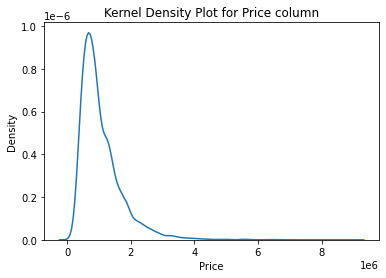

In [73]:
#price에 대한 분포 확인하기
x=df_2['Price']
sns.kdeplot(x)    
plt.title("Kernel Density Plot for Price column")
plt.show()

In [77]:
df_2.head()

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,2005.0,-37.80720,144.96230,0,17496.0
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,2005.0,-37.81060,144.96460,0,17496.0
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,1960.0,-37.81780,144.96070,0,17496.0
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,2005.0,-37.81060,144.96460,0,17496.0
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,2003.0,-37.80802,144.96168,0,17496.0


In [10]:
#object로 입력되어있는경우는 boxplot을 사용할 수 없음, drop하고 나머지로 확인하기


In [ ]:
#주피터 노트북에서 그래프가 안보일때 실행하는 명령
import plotly.offline as pyo
pyo.init_notebook_mode()

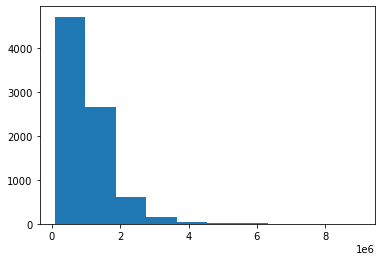

In [78]:
#히스토그램 그리기
plt.hist(df_2['Price'])
plt.show()

In [81]:
df_2.describe()
#describe를 통해 확인한결과, 이상치는 크게 없어보인다.

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
count,8174.000000,8174.000000,8.174000e+03,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000
mean,2.936384,0.435283,1.064590e+06,1.325544,10.031466,3105.154514,2.912528,1.575728,1.590653,493.846954,1964.896501,-37.809127,144.993242,1.318938,7473.976266
std,0.980348,0.657502,6.664493e+05,0.846085,5.916863,90.259053,0.977194,0.705212,0.937045,990.013248,37.128773,0.079304,0.103071,1.319578,4350.038814
min,1.000000,0.000000,8.500000e+04,0.000000,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.164920,144.542370,0.000000,389.000000
25%,2.000000,0.000000,6.200000e+05,1.000000,6.100000,3044.000000,2.000000,1.000000,1.000000,158.000000,1940.000000,-37.856797,144.928800,0.000000,4442.000000
50%,3.000000,0.000000,8.800000e+05,1.000000,9.200000,3084.000000,3.000000,1.000000,2.000000,389.500000,1970.000000,-37.804200,144.998300,1.000000,6567.000000
75%,4.000000,1.000000,1.319375e+06,2.000000,12.900000,3148.000000,4.000000,2.000000,2.000000,641.000000,1999.000000,-37.758018,145.055800,2.000000,10331.000000
max,10.000000,2.000000,9.000000e+06,4.000000,47.400000,3977.000000,10.000000,8.000000,10.000000,37000.000000,2018.000000,-37.408530,145.526350,7.000000,21650.000000


In [79]:
#boxplot을 사용해 outlier를 시각적으로 표현할 수 있다.
#subplot을 사용하여 여러 그래프를 동시에 표현할 수 있다.
def boxplot_vis(data, target_name):
    plt.figure(figsize=(30, 30))
    for col_idx in range(len(data.columns)):
        # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(8, 2, col_idx+1)
        # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
        plt.boxplot(data[data.columns[col_idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
        # 그래프 타이틀: feature name
        plt.title("Feature" + "(" + target_name + "):" + data.columns[col_idx], fontsize = 20)
    plt.savefig('../figure/boxplot_' + target_name + '.png')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../figure/boxplot_dfX.png'

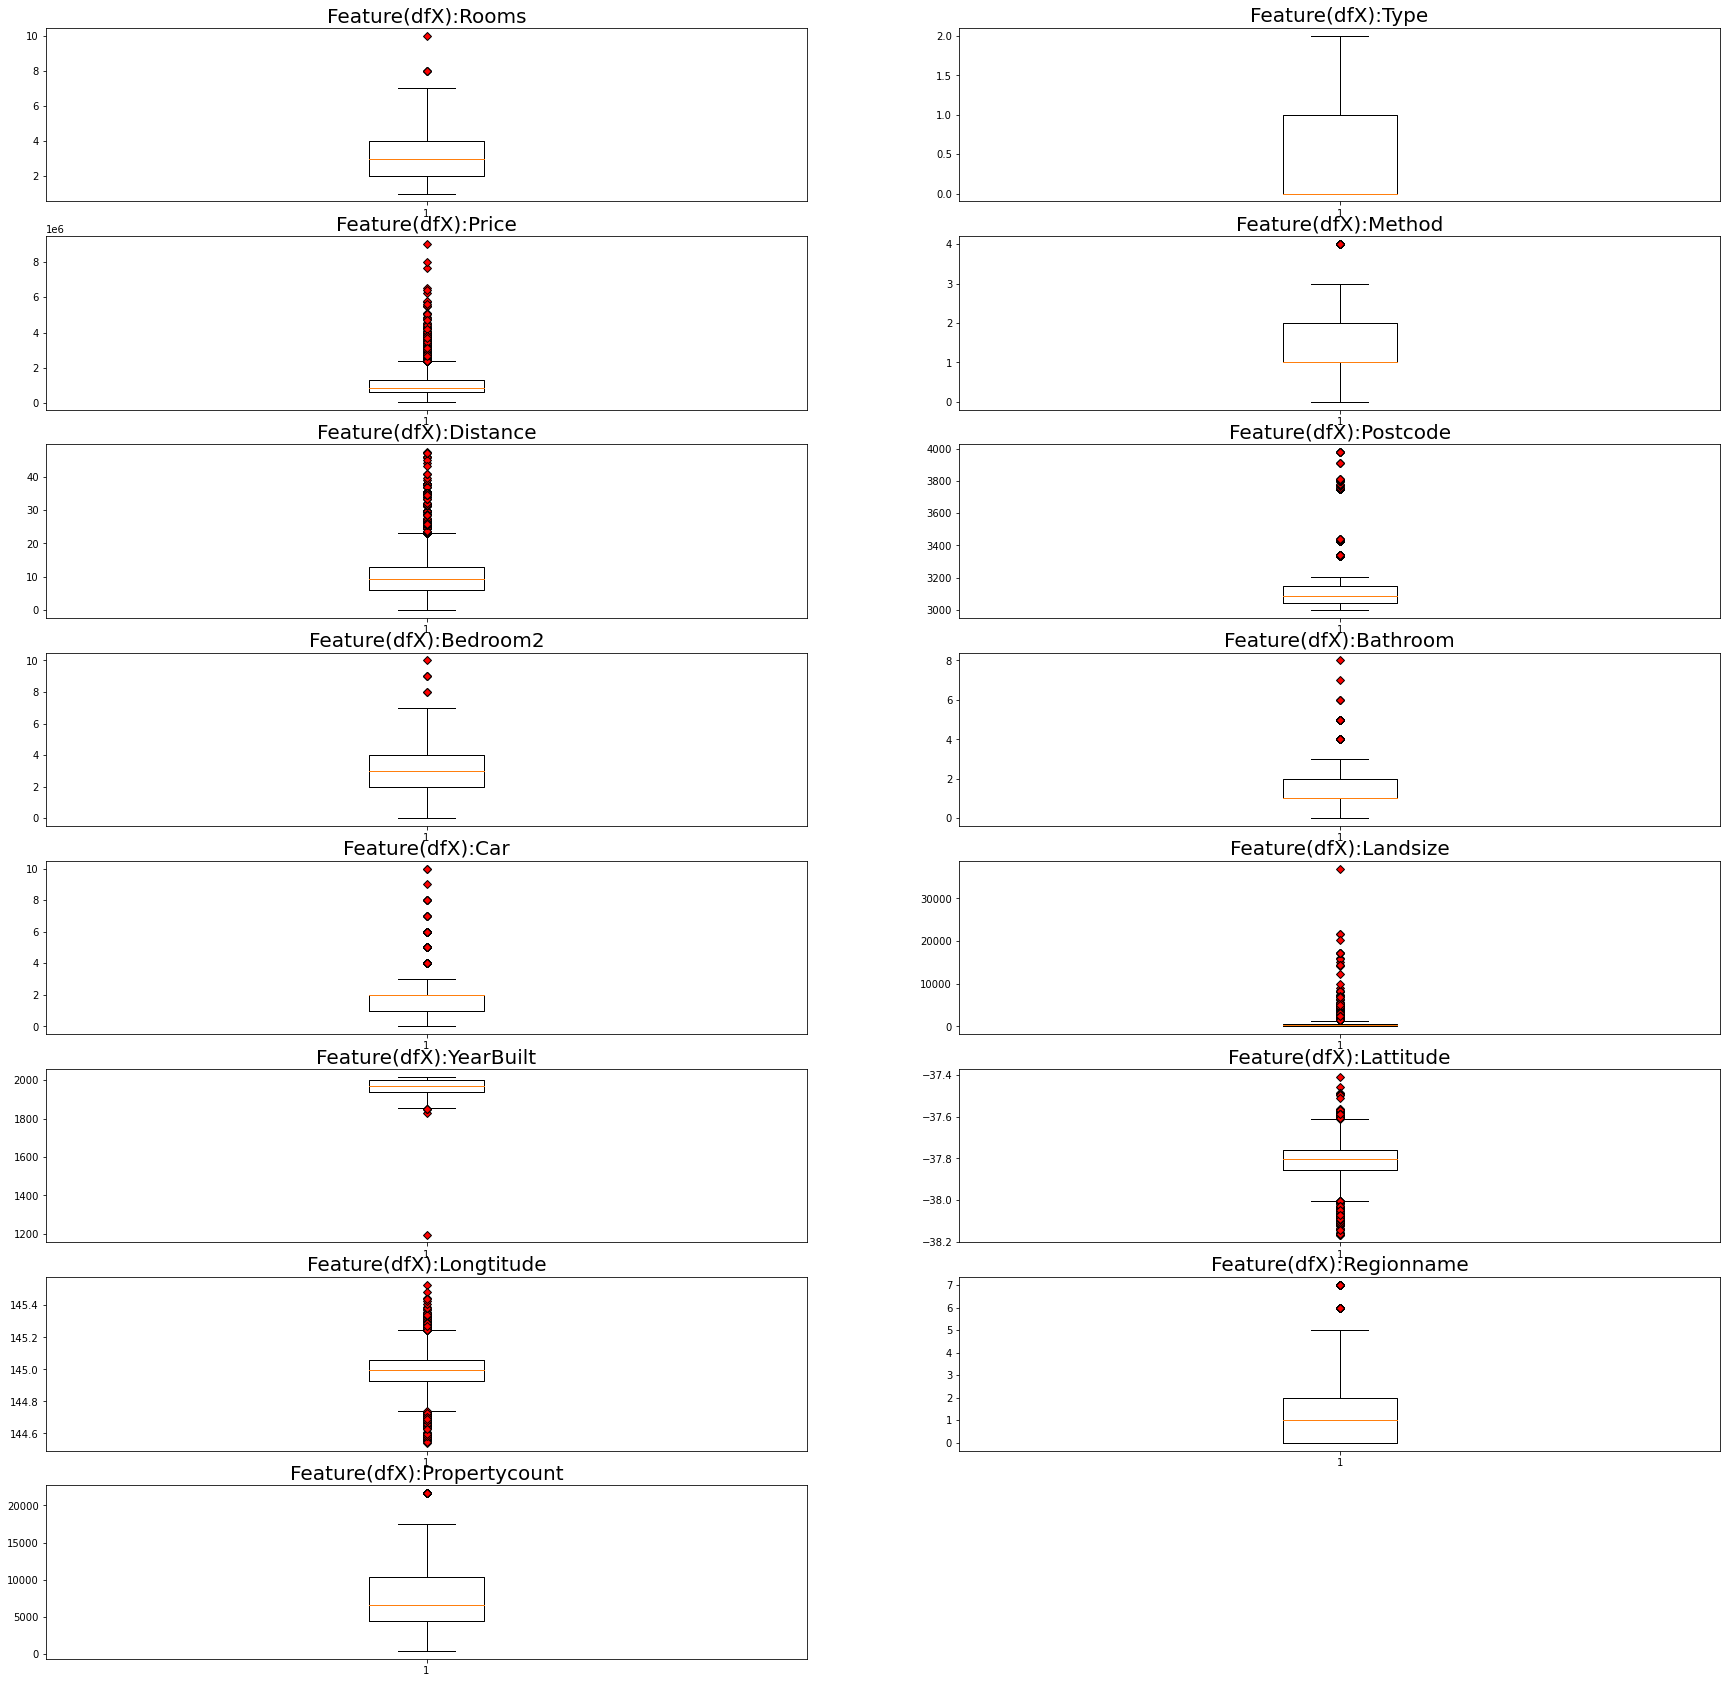

In [80]:
boxplot_vis(df_2, 'dfX')

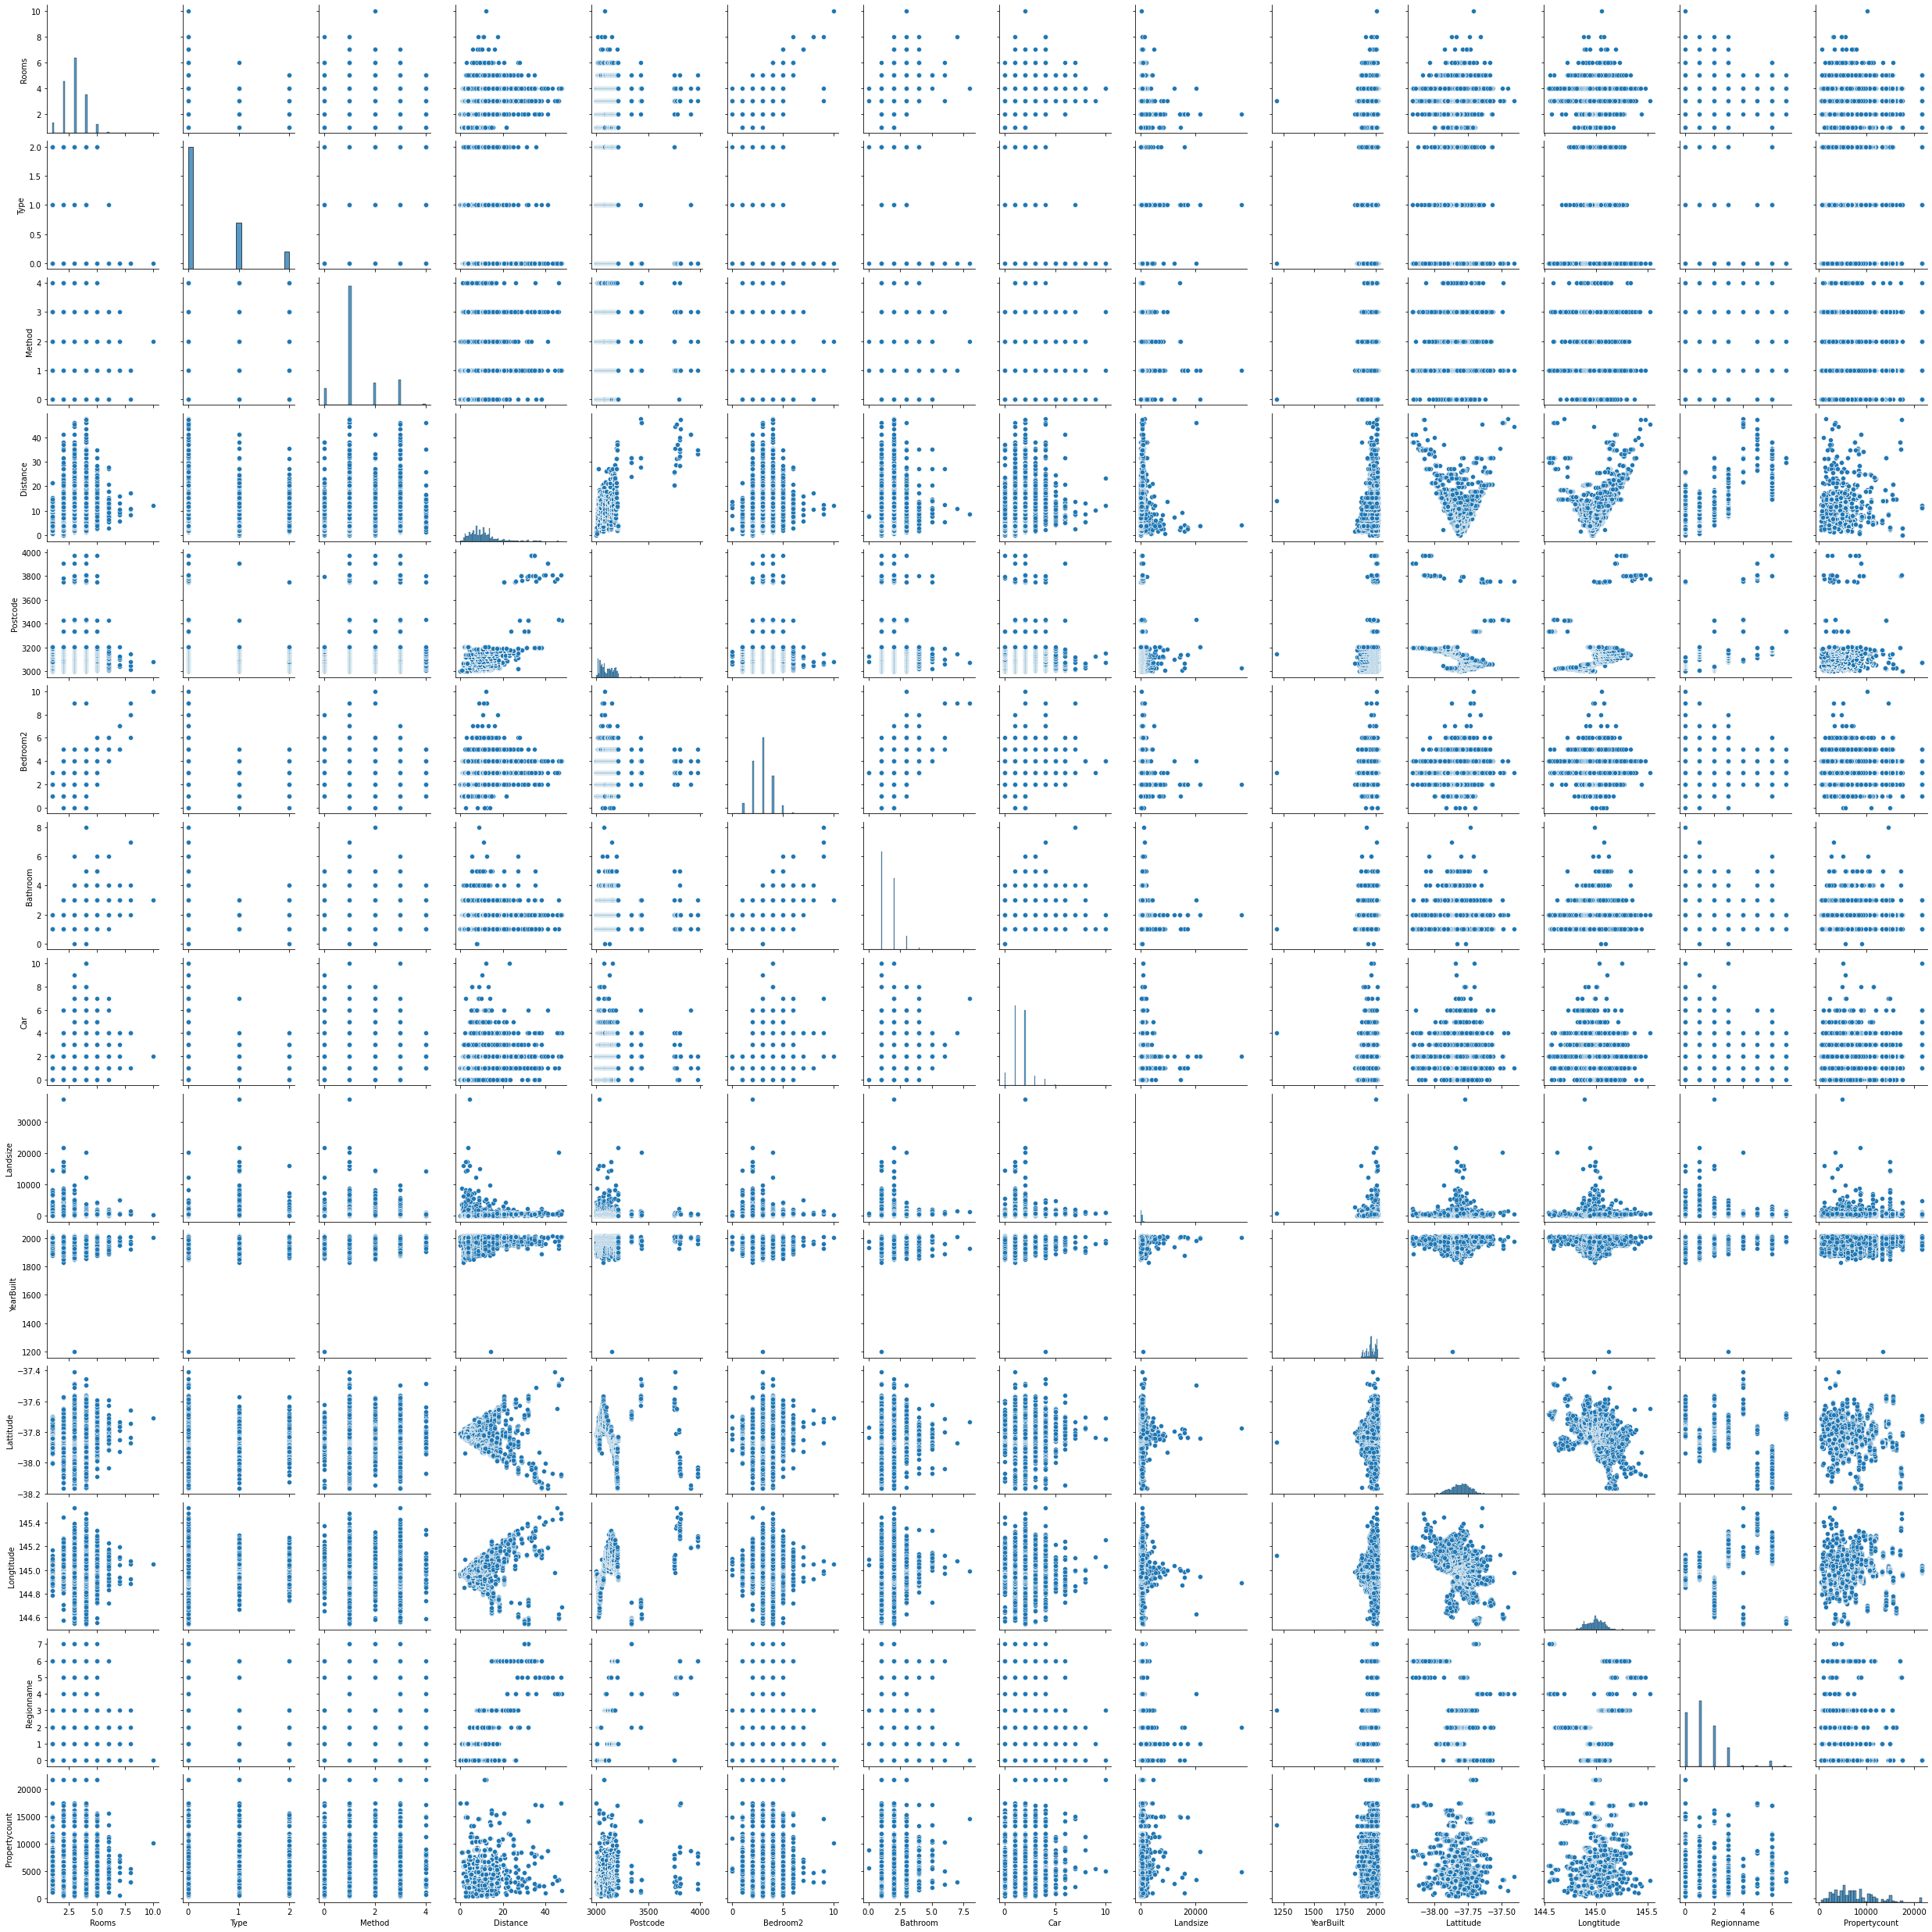

In [82]:
#설명변수별 목표변수와의 관계 시각화 (EDA)
dfX = df_2.drop(labels='Price', axis=1)
sns.pairplot(dfX)
plt.show()

In [112]:
#subplot을 사용한 히스토그램 그리기
#For문을 사용하여 column수가 많더라도 일일히 적지 않도록 만들기
#함수에 포함해야 하는 인수 : df, col_num
#make_subplot 함수 지정에 포함해야 하는 인수: 행개수, 열개수, n번째의 인수
def hist_vis(data, col_num):
    plt.figure(figsize=(30, 50)) #가로, 세로
    for col_idx in range(len(data.columns)):
        # 8행 2열 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(8, 2, col_idx+1)
        plt.hist(data[data.columns[col_idx]])
        # 그래프 타이틀: feature name
        plt.title("Feature" + "(" + col_num + "):" + data.columns[col_idx], fontsize = 20)
    plt.subplots_adjust(hspace=0.8,wspace=0.5)
    plt.show()

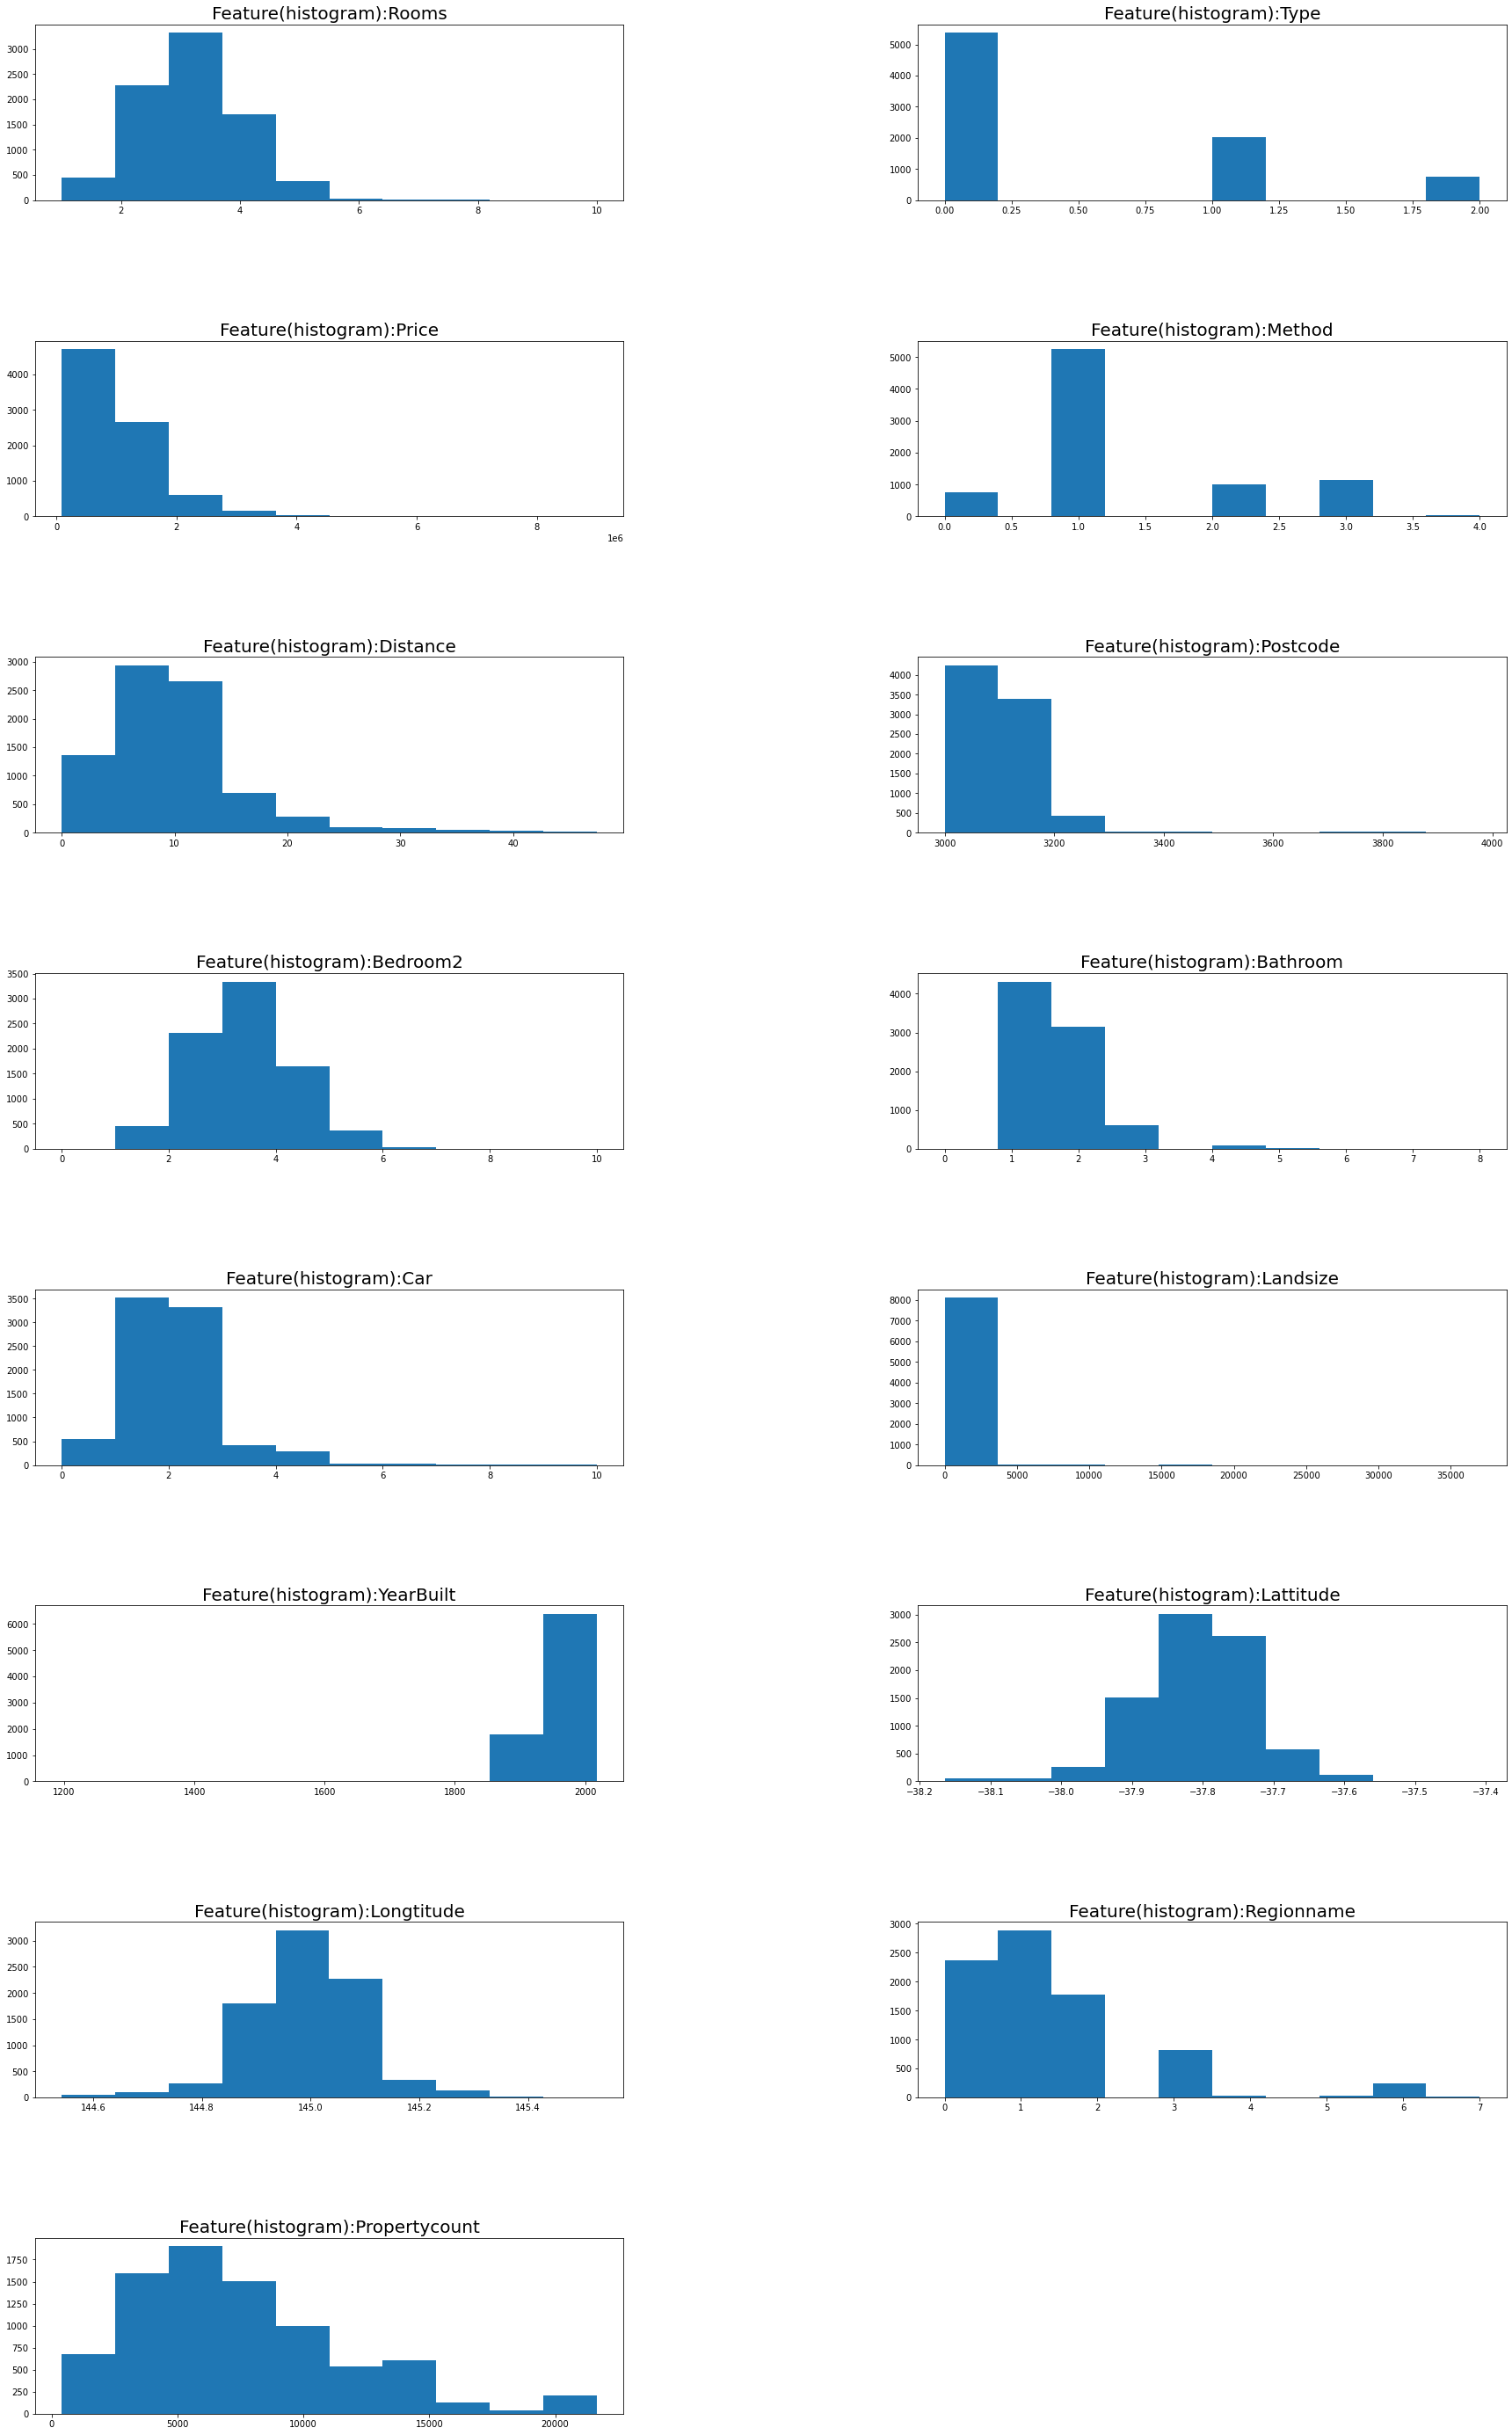

In [113]:
hist_vis(df_2, 'histogram')

# 2. 모델만들기, 제일 기본적인 회귀분석 모델(레이블 인코딩적용 , scaling하지 않음)

원핫인코딩 참조: https://jhryu1208.github.io/data/2021/01/09/ML_categorical_property/

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,...,Method_3,Method_4,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Regionname_4,Regionname_5,Regionname_6,Regionname_7
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,...,0,0,1,0,0,0,0,0,0,0
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,3,0,400000.0,2,33.3,3976.0,3.0,1.0,1.0,301.0,...,0,0,0,0,0,0,0,0,1,0
13404,5,0,720008.0,3,34.7,3977.0,5.0,3.0,2.0,528.0,...,1,0,0,0,0,0,0,0,1,0
10039,4,0,645000.0,3,34.7,3977.0,4.0,2.0,2.0,448.0,...,1,0,0,0,0,0,0,0,1,0
9723,4,0,555698.0,3,34.7,3977.0,4.0,2.0,1.0,534.0,...,1,0,0,0,0,0,0,0,1,0


In [3]:
#X,Y나누기
dfy = df_2['Price']
dfX = df_2.drop(['Price'], axis=1)

NameError: name 'df_2' is not defined

데이터 스케일링 링크: https://dacon.io/codeshare/4526

In [90]:
X_train, X_test, y_train, y_test, = train_test_split(dfX,dfy,train_size=0.7, test_size=0.3)

In [91]:
#statsmodel사용, scaling을 하지 않은 기본적인 모델
result = sm.OLS(y_train,X_train)
result_fit = result.fit()
result_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.875
Method:                 Least Squares   F-statistic:                              2863.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):                        0.00
Time:                        21:38:42   Log-Likelihood:                         -82526.
No. Observations:                5721   AIC:                                  1.651e+05
Df Residuals:                    5707   BIC:                                  1.652e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Rooms          2.527e+05   2.17e+04     11.631      0.000     2.1e+05    2.95e+05
Type          -1.308e+05   1.13e+04    -11.616      0.000   -1.53e+05   -1.09e+05
Method        -3.493e+04   6950.468     -5.026      0.000   -4.86e+04   -2.13e+04
Distance      -4.081e+04   1491.635    -27.357      0.000   -4.37e+04   -3.79e+04
Postcode       1302.5341     78.912     16.506      0.000    1147.837    1457.231
Bedroom2      -1.808e+04   2.19e+04     -0.827      0.408   -6.09e+04    2.48e+04
Bathroom       2.753e+05   1.14e+04     24.239      0.000    2.53e+05    2.98e+05
Car            6.166e+04   7079.529      8.710      0.000    4.78e+04    7.55e+04
Landsize         19.1399      6.517      2.937      0.003       6.365      31.915
YearBuilt     -3766.1961    192.864    -19.528      0.000   -4144.283   -3388.110
Lattitude     -1.142e+06   9.06e+04    -12.612      0.000   -1.32e+06   -9.65e+05
Longtitude    -2.721e+05   2.36e+04    -11.521      0.000   -3.18e+05   -2.26e+05
Regionname    -4865.3071   6127.751     -0.794      0.427   -1.69e+04    7147.412
Propertycount    -2.8469      1.439     -1.978      0.048      -5.669      -0.025
==============================================================================
Omnibus:                     4239.530   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           266528.531
Skew:                           2.957   Prob(JB):                         0.00
Kurtosis:                      35.911   Cond. No.                     1.47e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
#predict를 사용하여 test셋과 결과를 확인하기
y_pred = result_fit.predict(X_test)

In [93]:
print(r2_score(y_test,y_pred))
#test셋을 사용한 r2 score는 train셋을 사용한 r2 score보다 적게 나왔다. overfit을 의심해 볼 수 있다.

0.5774381418209049


# 2-1. 모델 만들기 - 원핫인코딩, robust scaling 적용

In [94]:
#피클 다시 불러오기
import pickle
df = pd.read_pickle("Melbourne_processed.pickle")


In [95]:
df.head(10)

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,...,Method_3,Method_4,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Regionname_4,Regionname_5,Regionname_6,Regionname_7
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,...,0,0,1,0,0,0,0,0,0,0
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,...,0,0,1,0,0,0,0,0,0,0
4005,3,1,760000.0,1,2.8,3000.0,2.0,2.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3994,2,1,470000.0,0,2.8,3000.0,2.0,1.0,2.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4003,2,1,675000.0,0,2.8,3000.0,2.0,2.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3980,2,1,450000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
9620,2,1,740000.0,0,0.0,3000.0,2.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
#X,Y나누기
dfy = df['Price']
dfX = df.drop(['Price'], axis=1)

In [6]:
X_train, X_test, y_train, y_test, = train_test_split(dfX,dfy,train_size=0.7, test_size=0.3)

In [9]:
#scaling적용하지않은모델
result = sm.OLS(y_train,X_train)
result_fit = result.fit()
result_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     415.0
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:05:21   Log-Likelihood:                -81800.
No. Observations:                5721   AIC:                         1.637e+05
Df Residuals:                    5696   BIC:                         1.638e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Rooms          1.943e+05   1.89e+04     10.300      0.000    1.57e+05    2.31e+05
Type          -2.132e+07   2.93e+06     -7.282      0.000   -2.71e+07   -1.56e+07
Method        -1.159e+07    1.6e+06     -7.259      0.000   -1.47e+07   -8.46e+06
Distance      -3.989e+04   1386.616    -28.765      0.000   -4.26e+04   -3.72e+04
Postcode        188.9641     88.824      2.127      0.033      14.836     363.093
Bedroom2      -1.061e+04   1.88e+04     -0.565      0.572   -4.75e+04    2.62e+04
Bathroom        2.35e+05   1.03e+04     22.828      0.000    2.15e+05    2.55e+05
Car            6.436e+04   6443.157      9.989      0.000    5.17e+04     7.7e+04
Landsize         18.8465      5.463      3.450      0.001       8.137      29.556
YearBuilt     -2918.1720    172.174    -16.949      0.000   -3255.698   -2580.646
Lattitude     -6.321e+05   1.06e+05     -5.981      0.000   -8.39e+05   -4.25e+05
Longtitude     5.944e+05   9.71e+04      6.120      0.000    4.04e+05    7.85e+05
Regionname    -5.154e+06   7.13e+05     -7.225      0.000   -6.55e+06   -3.76e+06
Propertycount    -0.2688      1.288     -0.209      0.835      -2.793       2.255
Type_0        -4.238e+07   5.86e+06     -7.238      0.000   -5.39e+07   -3.09e+07
Type_1        -2.144e+07   2.93e+06     -7.323      0.000   -2.72e+07   -1.57e+07
Type_2         5.934e+04   7025.780      8.447      0.000    4.56e+04    7.31e+04
Method_0      -3.595e+07   4.95e+06     -7.262      0.000   -4.57e+07   -2.62e+07
Method_1      -2.431e+07   3.35e+06     -7.248      0.000   -3.09e+07   -1.77e+07
Method_2      -1.279e+07   1.76e+06     -7.281      0.000   -1.62e+07   -9.35e+06
Method_3      -1.156e+06   1.62e+05     -7.150      0.000   -1.47e+06   -8.39e+05
Method_4       1.044e+07   1.44e+06      7.264      0.000    7.62e+06    1.33e+07
Regionname_0  -2.621e+07   3.59e+06     -7.293      0.000   -3.33e+07   -1.92e+07
Regionname_1  -2.074e+07   2.89e+06     -7.180      0.000   -2.64e+07   -1.51e+07
Regionname_2  -1.591e+07   2.16e+06     -7.374      0.000   -2.01e+07   -1.17e+07
Regionname_3  -1.067e+07   1.47e+06     -7.261      0.000   -1.35e+07   -7.79e+06
Regionname_4  -5.116e+06   7.25e+05     -7.057      0.000   -6.54e+06   -3.69e+06
Regionname_5  -2.771e+05   9.73e+04     -2.849      0.004   -4.68e+05   -8.64e+04
Regionname_6   4.849e+06   6.68e+05      7.255      0.000    3.54e+06    6.16e+06
Regionname_7   1.031e+07   1.44e+06      7.149      0.000    7.48e+06    1.31e+07
==============================================================================
Omnibus:                     3643.456   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111286.856
Skew:                           2.560   Prob(JB):                         0.00
Kurtosis:                      23.992   Cond. No.            

In [7]:
#원핫인코딩과 scaling 적용하기
#이전의 Box plot에서 이상치가 존재하는것을 알았으니, Robust scaling 사용하기
#변수 scaling시 train은 fit을 적용하고, test는 fit을 적용하지 않는다.
from sklearn.preprocessing import RobustScaler

rbs = RobustScaler()
X_train_scaled = rbs.fit_transform(X_train)
X_test_scaled = rbs.transform(X_test)

In [12]:
result = sm.OLS(y_train,X_train_scaled)
result_fit = result.fit()
result_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     415.0
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:05:51   Log-Likelihood:                -81800.
No. Observations:                5721   AIC:                         1.637e+05
Df Residuals:                    5696   BIC:                         1.638e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.886e+05   3.77e+04     10.300      0.000    3.15e+05    4.63e+05
x2         -6.635e+04   6732.266     -9.856      0.000   -7.96e+04   -5.32e+04
x3           466.7297    1.2e+04      0.039      0.969    -2.3e+04    2.39e+04
x4         -2.832e+05   9844.972    -28.765      0.000   -3.02e+05   -2.64e+05
x5          1.965e+04   9237.682      2.127      0.033    1542.895    3.78e+04
x6         -2.123e+04   3.76e+04     -0.565      0.572   -9.49e+04    5.25e+04
x7           2.35e+05   1.03e+04     22.828      0.000    2.15e+05    2.55e+05
x8          6.436e+04   6443.157      9.989      0.000    5.17e+04     7.7e+04
x9          9121.7170   2643.970      3.450      0.001    3938.530    1.43e+04
x10        -1.751e+05   1.03e+04    -16.949      0.000   -1.95e+05   -1.55e+05
x11        -6.227e+04   1.04e+04     -5.981      0.000   -8.27e+04   -4.19e+04
x12         7.584e+04   1.24e+04      6.120      0.000    5.15e+04       1e+05
x13         4.978e+05   2.01e+04     24.729      0.000    4.58e+05    5.37e+05
x14        -1592.4318   7627.614     -0.209      0.835   -1.65e+04    1.34e+04
x15         1.257e+05   5682.666     22.120      0.000    1.15e+05    1.37e+05
x16         -1.85e+05   1.09e+04    -17.036      0.000   -2.06e+05   -1.64e+05
x17         5.934e+04   7025.780      8.447      0.000    4.56e+04    7.31e+04
x18        -1.145e+04   1.33e+04     -0.861      0.389   -3.75e+04    1.46e+04
x19         3.949e+04   8834.174      4.470      0.000    2.22e+04    5.68e+04
x20        -3.839e+04    1.8e+04     -2.128      0.033   -7.38e+04   -3017.667
x21         3667.4914   2.63e+04      0.139      0.889   -4.79e+04    5.52e+04
x22         6690.8522   2.83e+04      0.236      0.813   -4.89e+04    6.22e+04
x23         1.161e+06   1.86e+04     62.337      0.000    1.12e+06     1.2e+06
x24         1.234e+06   1.69e+04     73.047      0.000     1.2e+06    1.27e+06
x25          6.59e+05   2.12e+04     31.043      0.000    6.17e+05    7.01e+05
x26         5.001e+05   2.86e+04     17.487      0.000    4.44e+05    5.56e+05
x27         6.479e+05    8.2e+04      7.905      0.000    4.87e+05    8.09e+05
x28         8.383e+04   8.47e+04      0.990      0.322   -8.22e+04     2.5e+05
x29        -1.931e+05   5.22e+04     -3.696      0.000   -2.95e+05   -9.07e+04
x30        -1.361e+05   7.86e+04     -1.732      0.083    -2.9e+05     1.8e+04
==============================================================================
Omnibus:                     3643.456   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111286.856
Skew:                           2.560   Prob(JB):                         0.00
Kurtosis:                      23.992   Cond. No.                     1.54e+16
==============================================================================

N

In [13]:
#predict를 사용하여 test셋과 결과를 확인하기
y_pred = result_fit.predict(X_test_scaled)

In [14]:
print(r2_score(y_test,y_pred))

0.5999523547539815


R^2의 값의 차이가 좁혀졌지만, 아직도 R^2값의 변화가 존재하며, overfit을 완전히 해결한것은아니다. 모델의 R^2값은 scalaing을 하나 하지 않으나 별 차이를 보이지 않았다.

## RMSLE 계산을 위한 log 필드 추가

In [121]:
df['price_log'] = np.log(df['Price'] + 1)

In [122]:
dfy = df['price_log']
dfX = df.drop(['Price', 'price_log'], axis=1)

In [123]:
X_train, X_test, y_train, y_test, = train_test_split(dfX,dfy,train_size=0.7, test_size=0.3)

In [124]:
result = sm.OLS(y_train,X_train)
result_fit = result.fit()
result_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     725.2
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:04:01   Log-Likelihood:                -612.83
No. Observations:                5721   AIC:                             1276.
Df Residuals:                    5696   BIC:                             1442.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Rooms             0.1655      0.013     12.429      0.000       0.139       0.192
Type            -27.5601      2.075    -13.282      0.000     -31.628     -23.492
Method          -15.0051      1.132    -13.258      0.000     -17.224     -12.786
Distance         -0.0387      0.001    -40.061      0.000      -0.041      -0.037
Postcode          0.0001   5.81e-05      2.390      0.017    2.49e-05       0.000
Bedroom2          0.0160      0.013      1.215      0.224      -0.010       0.042
Bathroom          0.1457      0.007     20.816      0.000       0.132       0.159
Car               0.0491      0.004     11.151      0.000       0.040       0.058
Landsize       1.425e-05    3.6e-06      3.956      0.000    7.19e-06    2.13e-05
YearBuilt        -0.0022      0.000    -17.529      0.000      -0.002      -0.002
Lattitude        -0.9608      0.073    -13.106      0.000      -1.105      -0.817
Longtitude        0.8013      0.069     11.654      0.000       0.667       0.936
Regionname       -6.6984      0.505    -13.253      0.000      -7.689      -5.708
Propertycount   -2.5e-06   8.81e-07     -2.838      0.005   -4.23e-06   -7.73e-07
Type_0          -54.8629      4.149    -13.222      0.000     -62.997     -46.729
Type_1          -27.7693      2.075    -13.384      0.000     -31.837     -23.702
Type_2            0.1046      0.005     21.548      0.000       0.095       0.114
Method_0        -46.5499      3.508    -13.269      0.000     -53.427     -39.672
Method_1        -31.4440      2.376    -13.231      0.000     -36.103     -26.785
Method_2        -16.5435      1.245    -13.289      0.000     -18.984     -14.103
Method_3         -1.4867      0.115    -12.947      0.000      -1.712      -1.262
Method_4         13.4965      1.019     13.250      0.000      11.500      15.493
Regionname_0    -33.8957      2.547    -13.307      0.000     -38.889     -28.902
Regionname_1    -26.9974      2.047    -13.190      0.000     -31.010     -22.985
Regionname_2    -20.4991      1.529    -13.403      0.000     -23.497     -17.501
Regionname_3    -13.7186      1.041    -13.175      0.000     -15.760     -11.677
Regionname_4     -6.6509      0.513    -12.975      0.000      -7.656      -5.646
Regionname_5     -0.3992      0.066     -6.024      0.000      -0.529      -0.269
Regionname_6      6.3810      0.473     13.491      0.000       5.454       7.308
Regionname_7     13.2523      1.021     12.976      0.000      11.250      15.254
==============================================================================
Omnibus:                      405.592   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1849.892
Skew:                           0.176   Prob(JB):                         0.00
Kurtosis:                       5.763   Cond. No.            

In [125]:
y_pred = result_fit.predict(X_test)

In [126]:
diff = np.log(y_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.01892091373826411


## 4. 과적합 여부를 확인하기 위한 Cross Validation

In [320]:
#원핫인코딩을 하지 않은 기본 df에 대해서 cv를 진행함
df = pd.read_pickle("Melbourne_processed_label.pickle")
df.head()

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount
3983,1,1,386000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,1976.0,-37.8127,144.9627,0,17496.0
4005,3,1,760000.0,0,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,-37.8095,144.9691,0,17496.0
4003,2,1,675000.0,1,2.8,3000.0,2.0,2.0,1.0,0.0,2014.0,-37.8161,144.9712,0,17496.0
4002,2,1,733000.0,0,2.8,3000.0,2.0,2.0,1.0,0.0,1965.0,-37.8166,144.9635,0,17496.0
4000,1,1,440000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,1920.0,-37.8168,144.9691,0,17496.0


In [321]:
#df_train과 df_test로 나누어놓기
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)
df_train.shape, df_test.shape

((5721, 15), (2453, 15))

In [322]:
#X,Y나누기
dfy = df['Price']
dfX = df.drop(['Price'], axis=1)

In [323]:
X_train, X_test, y_train, y_test, = train_test_split(dfX,dfy,train_size=0.7, test_size=0.3)

In [324]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [325]:
k_fold=KFold(n_splits=10, shuffle=True, random_state=0)

In [326]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()

In [327]:
scores=cross_val_score(model, X_train, y_train, cv=k_fold, scoring='r2' )
scores

array([0.55529099, 0.5984537 , 0.56740961, 0.57671224, 0.62870113,
       0.60734625, 0.60047244, 0.63264042, 0.45861441, 0.598685  ])

In [337]:
result = sm.OLS(y_train,X_train)
result_fit = result.fit()
result_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              2900.
Date:                Thu, 27 Apr 2023   Prob (F-statistic):                        0.00
Time:                        21:31:04   Log-Likelihood:                         -82473.
No. Observations:                5721   AIC:                                  1.650e+05
Df Residuals:                    5707   BIC:                                  1.651e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Rooms           2.79e+05   2.05e+04     13.623      0.000    2.39e+05    3.19e+05
Type          -1.256e+05    1.1e+04    -11.430      0.000   -1.47e+05   -1.04e+05
Method        -3.052e+04   5103.548     -5.979      0.000   -4.05e+04   -2.05e+04
Distance      -4.131e+04   1485.925    -27.801      0.000   -4.42e+04   -3.84e+04
Postcode       1197.3926     74.685     16.033      0.000    1050.982    1343.804
Bedroom2      -3.807e+04   2.05e+04     -1.854      0.064   -7.83e+04    2178.650
Bathroom       2.744e+05   1.14e+04     24.103      0.000    2.52e+05    2.97e+05
Car             6.19e+04   7246.400      8.542      0.000    4.77e+04    7.61e+04
Landsize         18.1029      6.274      2.885      0.004       5.803      30.403
YearBuilt     -3737.2171    190.973    -19.569      0.000   -4111.597   -3362.837
Lattitude     -1.136e+06   8.86e+04    -12.828      0.000   -1.31e+06   -9.63e+05
Longtitude     -2.69e+05   2.31e+04    -11.622      0.000   -3.14e+05   -2.24e+05
Regionname      477.4892   6069.405      0.079      0.937   -1.14e+04    1.24e+04
Propertycount    -2.2525      1.431     -1.574      0.116      -5.058       0.553
==============================================================================
Omnibus:                     4347.358   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           293417.209
Skew:                           3.054   Prob(JB):                         0.00
Kurtosis:                      37.548   Cond. No.                     1.45e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [338]:
y_pred = result_fit.predict(X_test)

In [342]:
from sklearn.metrics import make_scorer

def get_rmsle_1(y_test, y_pred):
    diff =  np.log(y_test + 1) - np.log(y_pred + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

In [343]:
rmsle_scorer_1 = make_scorer(get_rmsle_1, greater_is_better=False)

## 다중공선성 문제 확인

### 1. Scatter plot을 그려서 확인

scatter plot은 원본데이터를 사용하여 확인한다.

In [39]:
df_3 = pd.read_csv('melb_data.csv')

In [40]:
dfX_3 = df_3.drop(labels =['Price'], axis=1, errors='ignore')

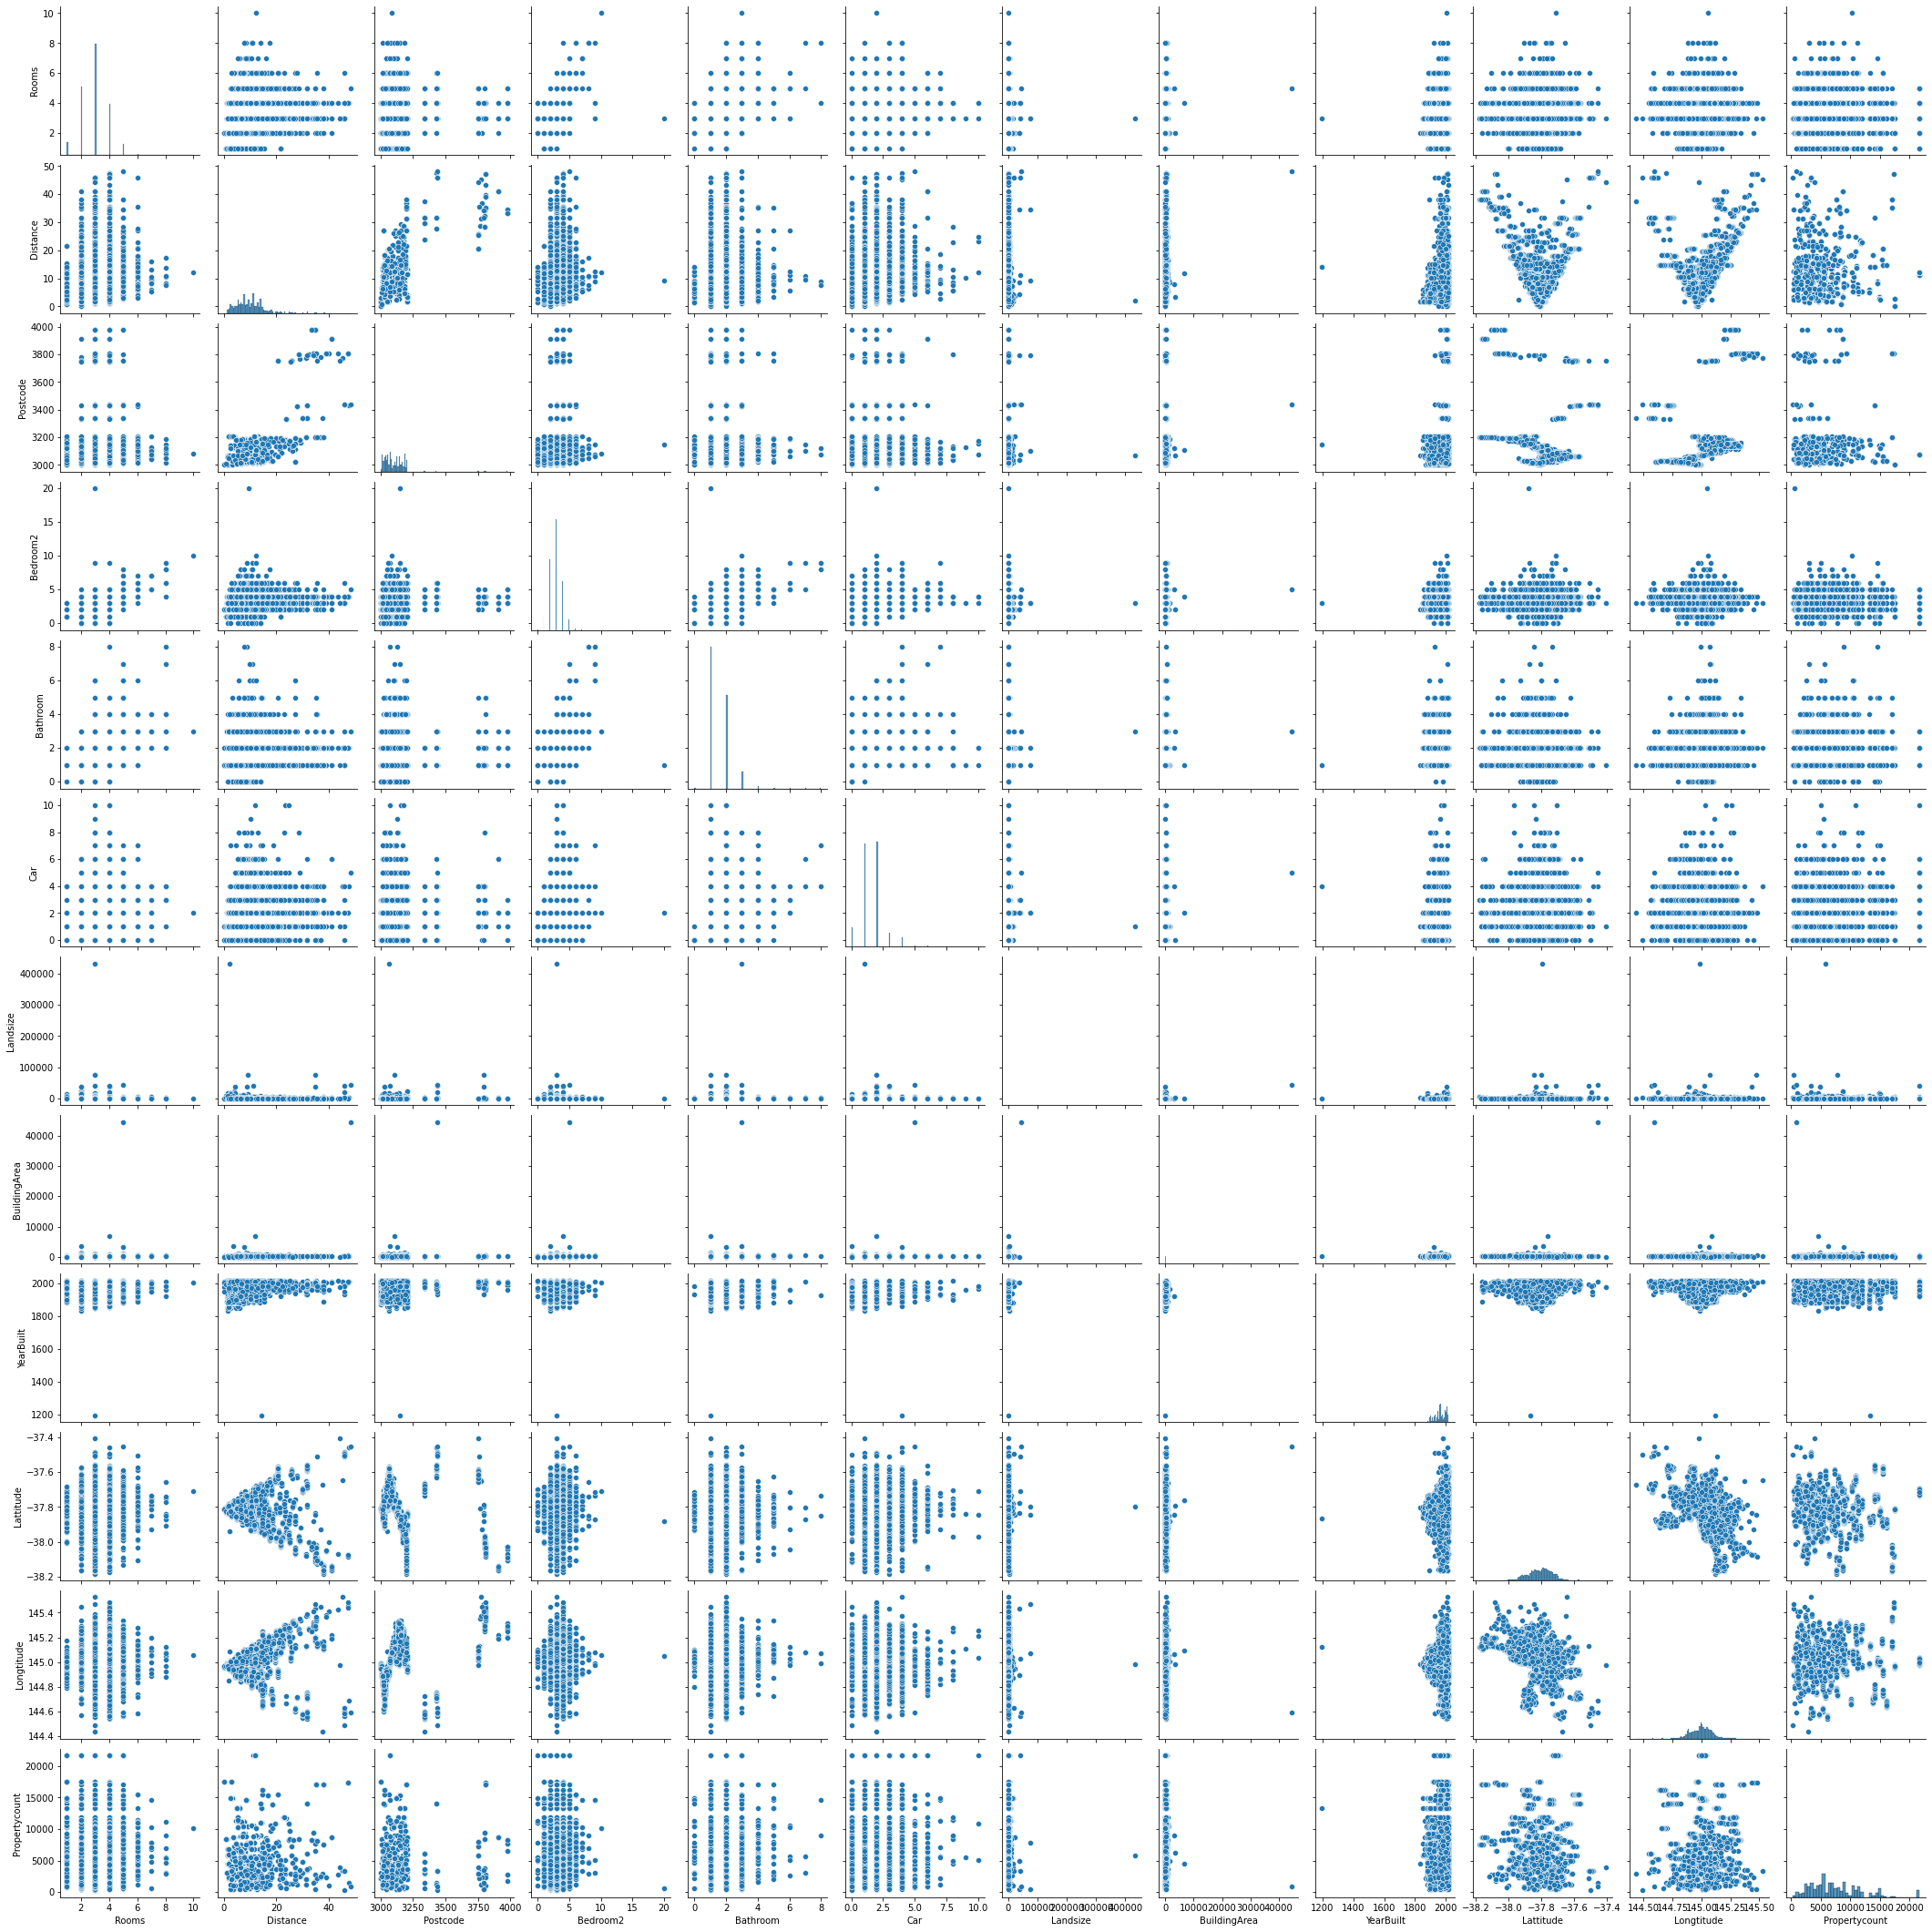

In [41]:
sns.pairplot(dfX_3)
plt.show()

### 2. 상관관계 plot을 그려서 확인

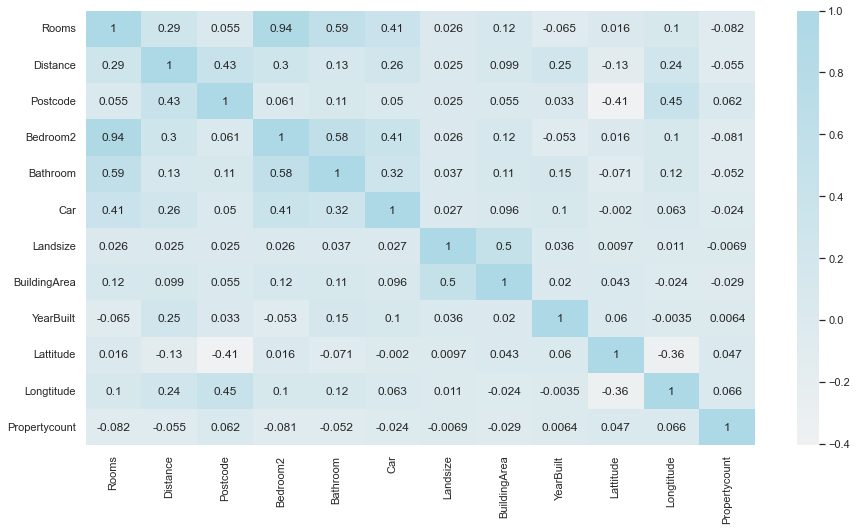

In [43]:
cmap = sns.light_palette("lightblue", as_cmap=True)
sns.heatmap(dfX_3.corr(), annot=True, cmap=cmap)
sns.set(rc = {'figure.figsize':(20,20)})
plt.show()

Rooms와 Bedroom2가 높은 상관관계를 가지고 있어, 큰 다중공선성 문제를 가지고 있는것 같아 보인다.

### 3. Corr coefficient table 그려서 확인하기 

In [58]:
dfX_3.corr()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
Rooms,1.000000,0.294203,0.055303,0.944190,0.592934,0.408483,0.025678,0.124127,-0.065413,0.015948,0.100771,-0.081530
Distance,0.294203,1.000000,0.431514,0.295927,0.127155,0.262994,0.025004,0.099481,0.246379,-0.130723,0.239425,-0.054910
Postcode,0.055303,0.431514,1.000000,0.060584,0.113664,0.050289,0.024558,0.055475,0.032863,-0.406104,0.445357,0.062304
Bedroom2,0.944190,0.295927,0.060584,1.000000,0.584685,0.405325,0.025646,0.122319,-0.053319,0.015925,0.102238,-0.081350
Bathroom,0.592934,0.127155,0.113664,0.584685,1.000000,0.322246,0.037130,0.111933,0.152702,-0.070594,0.118971,-0.052201
Car,0.408483,0.262994,0.050289,0.405325,0.322246,1.000000,0.026770,0.096101,0.104515,-0.001963,0.063395,-0.024295
Landsize,0.025678,0.025004,0.024558,0.025646,0.037130,0.026770,1.000000,0.500485,0.036451,0.009695,0.010833,-0.006854
BuildingArea,0.124127,0.099481,0.055475,0.122319,0.111933,0.096101,0.500485,1.000000,0.019665,0.043420,-0.023810,-0.028840
YearBuilt,-0.065413,0.246379,0.032863,-0.053319,0.152702,0.104515,0.036451,0.019665,1.000000,0.060445,-0.003470,0.006361
Lattitude,0.015948,-0.130723,-0.406104,0.015925,-0.070594,-0.001963,0.009695,0.043420,0.060445,1.000000,-0.357634,0.047086


### 4. VIF지수 계산

- StatsModels에서 variance_inflation_factor 명령으로 VIF를 계산가능
- dfX에는 string이나 float유형의 데이터가 들어가 있으면 계산이 안됨

In [302]:
#피클 다시 불러오기
import pickle
df = pd.read_pickle("Melbourne_processed.pickle")


In [303]:
df.columns

Index(['Rooms', 'Type', 'Price', 'Method', 'Distance', 'Postcode', 'Bedroom2',
       'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount', 'Type_0', 'Type_1', 'Type_2', 'Method_0',
       'Method_1', 'Method_2', 'Method_3', 'Method_4', 'Regionname_0',
       'Regionname_1', 'Regionname_2', 'Regionname_3', 'Regionname_4',
       'Regionname_5', 'Regionname_6', 'Regionname_7'],
      dtype='object')

In [304]:
dfX_4 = df[['Rooms', 'Type', 'Price', 'Method', 'Distance', 'Postcode', 'Bedroom2',
       'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount']]

In [305]:
dfX_4 = dfX_4.astype('int64')

In [306]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX_4.values, i) for i in range(dfX_4.shape[1])]
vif["features"] = dfX_4.columns
vif

,VIF Factor,features
0,129.476188,Rooms
1,2.248922,Type
2,8.147692,Price
3,3.492160,Method
4,8.758805,Distance
5,1765.778836,Postcode
6,125.731171,Bedroom2
7,12.432106,Bathroom
8,5.174409,Car
9,1.274680,Landsize


위의 표에 따라 확실히 다중공선성을 보이는 Bedroom2, Postcode, YearBuilt, Lattitude, Longtitude를 제외하고 모델을 다시 만들어보면,

In [297]:
colnames = dfX.columns

In [299]:
colnames = colnames.drop(['Bedroom2', 'Postcode', 'YearBuilt', 'Lattitude','Longtitude'], errors='ignore')

In [300]:
colnames

Index(['Rooms', 'Type', 'Method', 'Distance', 'Bathroom', 'Car', 'Landsize',
       'Regionname', 'Propertycount'],
      dtype='object')

In [301]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train

,Rooms,Type,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Longtitude,Regionname,Propertycount,Price
6385,2,1,0,4.6,3142.0,2.0,1.0,1.0,0.0,2008.0,145.0173,1,7217.0,575000.0
4763,3,0,0,3.8,3207.0,3.0,1.0,0.0,184.0,1905.0,144.9443,1,8648.0,1384000.0
7495,4,0,2,9.2,3104.0,4.0,3.0,2.0,627.0,1970.0,145.0945,1,7809.0,1725000.0
8216,3,0,0,9.9,3044.0,3.0,1.0,2.0,321.0,1950.0,144.9424,0,7485.0,708000.0
10574,3,0,2,9.5,3034.0,3.0,1.0,1.0,582.0,1965.0,144.8603,2,4502.0,720000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,3,0,3,6.6,3011.0,3.0,1.0,0.0,216.0,1890.0,144.8941,2,2417.0,880000.0
1418,2,1,2,5.9,3055.0,2.0,1.0,1.0,0.0,1970.0,144.9394,0,7082.0,380000.0
5387,3,1,0,2.6,3121.0,3.0,2.0,1.0,0.0,1999.0,144.9970,0,14949.0,945000.0
3588,3,0,0,5.6,3101.0,3.0,2.0,2.0,597.0,1970.0,145.0299,1,10331.0,1490000.0


In [111]:
model = sm.OLS.from_formula("price_log~" + "+".join(colnames), data=df_train)
result= model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     786.3
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:39:05   Log-Likelihood:                -960.14
No. Observations:                5721   AIC:                             1960.
Df Residuals:                    5701   BIC:                             2093.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0410      0.009    544.311

VIF계산

In [128]:
dfX_5 = df[['Rooms', 'Type', 'Method', 'Distance',
       'Bathroom', 'Car', 'Landsize',
       'Regionname', 'Propertycount']]

In [129]:
dfX_5 = dfX_5.astype('int64')

In [130]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX_5.values, i) for i in range(dfX_5.shape[1])]
vif["features"] = dfX_5.columns
vif

,VIF Factor,features
0,15.905456,Rooms
1,1.463642,Type
2,3.058498,Method
3,5.882573,Distance
4,10.225324,Bathroom
5,4.950750,Car
6,1.267452,Landsize
7,3.176548,Regionname
8,3.455554,Propertycount


여전히 Rooms와 Bathroom과의 상관관계가 어느정도 존재하나, 전체적인 VIF Factor가 많이 줄어든것을 볼 수 있다.

In [118]:
y_pred = result_fit.predict(X_test)

In [120]:
diff = np.log(y_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.018885591286387143


RMSLE는 기본 모형과 큰 변화가 없음을 알 수 있다.

## Metric 계산코드

X_train, X_test, y_train, y_test

```python
from sklearn.metrics import make_scorer

def get_rmsle(y_train, y_pred):
    diff = np.log(y_pred + 1) - np.log(y_train + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)
```

## 패널티 회귀분석 (Penalized Regression Analysis)

    - 지나치게 많은 독립변수를 가지는 갖는 모델에 패널티를 부과하는 방식 으로 보다 간명한 회귀모델을 생성하기 위한 목적을 가진다.
    - 독립변수의 수가 지나치게 많은 경우 회귀모델이 제 성능을 발휘하지 못하는 경우가 존재함. (과적합) 회귀계수가 많을수록 정확한 예측이 불가능하고, 다중공선성문제가 발생할 가능성이 큼
    - 모델의 성능에 크게 기여하지 못하는 변수의 영향력을 제거하거나 축소
    - 최소자승법에의한 잔차(관측 - 예측)의 제곱합과 패널티항의합이 최소가되는 회귀계수를 추정

## 패널티 회귀분석 - Lasso

In [ ]:
#레이블인코딩 결과
df = pd.read_pickle("Melbourne_processed_label.pickle")
df.head()

In [355]:
#원핫 인코딩 결과
df = pd.read_pickle("Melbourne_processed.pickle")
df.head()

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,...,Method_3,Method_4,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Regionname_4,Regionname_5,Regionname_6,Regionname_7
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,...,0,0,1,0,0,0,0,0,0,0
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,...,0,0,1,0,0,0,0,0,0,0


In [356]:
df['price_log'] = np.log(df['Price'] + 1)

In [357]:
df

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,...,Method_4,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Regionname_4,Regionname_5,Regionname_6,Regionname_7,price_log
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,...,0,1,0,0,0,0,0,0,0,13.161586
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,13.369225
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,13.017005
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,12.899222
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,...,0,1,0,0,0,0,0,0,0,13.244583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,3,0,400000.0,2,33.3,3976.0,3.0,1.0,1.0,301.0,...,0,0,0,0,0,0,0,1,0,12.899222
13404,5,0,720008.0,3,34.7,3977.0,5.0,3.0,2.0,528.0,...,0,0,0,0,0,0,0,1,0,13.487019
10039,4,0,645000.0,3,34.7,3977.0,4.0,2.0,2.0,448.0,...,0,0,0,0,0,0,0,1,0,13.377007
9723,4,0,555698.0,3,34.7,3977.0,4.0,2.0,1.0,534.0,...,0,0,0,0,0,0,0,1,0,13.227982


Model Evaluation 함수 설정하기

In [251]:
def split_df(df):
    return df[:5721], df[5721:]

In [252]:
def predict_price(model, select_columns):
    df_train, df_test = split_df(df)

    X_train = df_train[select_columns]
    y_train = df_train['price_log']
    X_test = df_test[select_columns]
    
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred) - 1

    return y_pred

In [358]:
from sklearn.metrics import make_scorer

def get_rmsle(y_actual, y_pred):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

In [359]:
rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

In [255]:
df.columns

Index(['Rooms', 'Type', 'Price', 'Method', 'Distance', 'Postcode', 'Bedroom2',
       'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount', 'Type_0', 'Type_1', 'Type_2', 'Method_0',
       'Method_1', 'Method_2', 'Method_3', 'Method_4', 'Regionname_0',
       'Regionname_1', 'Regionname_2', 'Regionname_3', 'Regionname_4',
       'Regionname_5', 'Regionname_6', 'Regionname_7', 'price_log'],
      dtype='object')

In [360]:
df_train, df_test = split_df(df)
#ml_columns에는 x만 포함
ml_columns = [
    'Rooms', 'Type', 'Method', 'Distance', 'Postcode', 'Bedroom2',
       'Bathroom', 'Car', 'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount', 'Type_0', 'Type_1', 'Type_2', 'Method_0',
       'Method_1', 'Method_2', 'Method_3', 'Method_4', 'Regionname_0',
       'Regionname_1', 'Regionname_2', 'Regionname_3', 'Regionname_4',
       'Regionname_5', 'Regionname_6', 'Regionname_7'
]
X_train = df_train[ml_columns].copy()
y_train = df_train['Price']
rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

In [237]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

hyperparams = {'max_iter': [7000, 10000, 20000, 30000], 
               'alpha': 1/np.array([0.1, 1, 2, 3, 4, 10, 30,2000,5000, 70000])
}

lasso_grid=GridSearchCV(estimator = Lasso(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)

lasso_grid.fit(X_train, y_train)
print(lasso_grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'alpha': 10.0, 'max_iter': 7000}


하이퍼파라미터 튜닝 
- max_liter: Gridsearch 최대반복횟수
- alpha: regularization 조절 인수(패널티의 크기), 역수로 사용을 하여 np.array의 값이 커지면 패널티의 값은 작아진다.

In [238]:
lasso_model = lasso_grid.best_estimator_
ml_pred = predict_price(lasso_model, ml_columns)

In [241]:
diff = np.log(ml_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.5586508343993613


## 패널티 회귀분석 - Ridge

In [257]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

hyperparams = {'max_iter': [1000, 1500, 2000, 2500, 3000], 
               'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]
}

ridge_grid=GridSearchCV(estimator = Ridge(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)

ridge_grid.fit(X_train, y_train)
print(ridge_grid.best_params_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
{'alpha': 1000, 'max_iter': 1000}


In [258]:
ridge_model = ridge_grid.best_estimator_
ml_pred = predict_price(ridge_model, ml_columns)

In [259]:
diff = np.log(ml_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.8309080084732102


## Random Forest

In [244]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [260]:
from sklearn.model_selection import GridSearchCV

n_estimators = [800, 1000, 1200]
max_depth = [10, 12, 15]
min_samples_split = [4, 5, 6]
min_samples_leaf = [4, 5, 6]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

rf_grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)

rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


KeyboardInterrupt: 

In [246]:
rf_model = rf_grid.best_estimator_
ml_pred = predict_price(rf_model, ml_columns)

In [247]:
diff = np.log(ml_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.727751381648705


## XGBoost

In [350]:
!pip install xgboost

In [361]:
from xgboost import XGBRegressor # 회귀트리 모델
from sklearn.model_selection import GridSearchCV

hyperparams = {'nthread':[4],
              'learning_rate': [0.05, 0.1, 0.15], 
              'max_depth': [4, 5],
              'min_child_weight': [3, 4, 5],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.6, 0.7],
              'n_estimators': [250, 500]}

xgb_grid = GridSearchCV(estimator = XGBRegressor(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)

xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 250, 'nthread': 4, 'subsample': 0.7}


In [362]:
xgb_model = xgb_grid.best_estimator_
ml_pred = predict_price(xgb_model, X_train.columns)

In [363]:
diff = np.log(ml_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.7941250281249533


## Gradient Boosting 

In [364]:
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 150, 200]
max_depth = [5, 7, 9]
min_samples_leaf = [8, 10, 12]
learning_rate = [0.1, 0.15, 0.2]
subsample = [0.6, 0.7, 0.8]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 
                    'min_samples_leaf': min_samples_leaf,
                    'learning_rate': learning_rate, 'subsample': subsample
              }

gb_grid=GridSearchCV(estimator = GradientBoostingRegressor(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)

gb_grid.fit(X_train, y_train)
print(gb_grid.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 8, 'n_estimators': 100, 'subsample': 0.6}


In [365]:
gb_model = gb_grid.best_estimator_
ml_pred = predict_price(gb_model, X_train.columns)

In [366]:
diff = np.log(ml_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.7877833854262634


# TreeModel을 사용한 변수선택 (원핫사용, 로그변환하지 않음)

In [377]:
import numpy as np # 각 모델에서 내부적으로 관련 라이브러리 사용 가능
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression                                 #basic linear
from sklearn.linear_model import Ridge, Lasso, ElasticNet                         #Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor     #Random Forest, Gradient Boosting
from xgboost import XGBRegressor                                                  #XGBoost

In [381]:
import pickle
df = pd.read_pickle("Melbourne_processed.pickle")

In [382]:
df

,Rooms,Type,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,...,Method_3,Method_4,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Regionname_4,Regionname_5,Regionname_6,Regionname_7
3999,2,1,520000.0,0,2.8,3000.0,1.0,1.0,1.0,4051.0,...,0,0,1,0,0,0,0,0,0,0
8086,2,1,640000.0,0,2.8,3000.0,2.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3987,1,1,450000.0,0,2.8,3000.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3989,1,1,400000.0,0,2.8,3000.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
12073,2,1,565000.0,1,0.0,3000.0,2.0,1.0,0.0,89.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,3,0,400000.0,2,33.3,3976.0,3.0,1.0,1.0,301.0,...,0,0,0,0,0,0,0,0,1,0
13404,5,0,720008.0,3,34.7,3977.0,5.0,3.0,2.0,528.0,...,1,0,0,0,0,0,0,0,1,0
10039,4,0,645000.0,3,34.7,3977.0,4.0,2.0,2.0,448.0,...,1,0,0,0,0,0,0,0,1,0
9723,4,0,555698.0,3,34.7,3977.0,4.0,2.0,1.0,534.0,...,1,0,0,0,0,0,0,0,1,0


In [384]:
dfy = df['Price']
dfX = df.drop(['Price'], axis=1)

In [385]:
X_train, X_test, y_train, y_test, = train_test_split(dfX,dfy,train_size=0.7, test_size=0.3)


In [386]:
ln_model = LinearRegression()
ln_lasso = Lasso()
ln_Ridge = Ridge()
ln_Elastic = ElasticNet()
ln_Random = RandomForestRegressor()
ln_XG = XGBRegressor()
ln_GBM = GradientBoostingRegressor()

models = [
    ln_model,
    ln_lasso,
    ln_Ridge,
    ln_Elastic,
    ln_Random,
    ln_XG,
    ln_GBM
]

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)           # K-Fold 사용
results = dict()
for alg in models:
    alg.fit(X_train, y_train)    
    score = cross_val_score(alg, X_train, y_train.values.ravel(), cv=k_fold, scoring='r2')
    results[alg.__class__.__name__] = np.mean(score)*100

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 459005089730273.2, tolerance: 245265383662.4476
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 407978920298752.4, tolerance: 215250439011.37277
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424299463964371.4, tolerance: 224619366222.17435
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

In [387]:
results

{'LinearRegression': 62.74017088508565,
 'Lasso': 62.740244356283895,
 'Ridge': 62.741543088757254,
 'ElasticNet': 56.32565711698187,
 'RandomForestRegressor': 79.19918492056415,
 'XGBRegressor': 79.56994825065514,
 'GradientBoostingRegressor': 77.15082167258946}

In [388]:
sorted(results.items(), key=lambda x: x[1], reverse=True) # reverse=True 면 높은 순서대로 정렬

[('XGBRegressor', 79.56994825065514),
 ('RandomForestRegressor', 79.19918492056415),
 ('GradientBoostingRegressor', 77.15082167258946),
 ('Ridge', 62.741543088757254),
 ('Lasso', 62.740244356283895),
 ('LinearRegression', 62.74017088508565),
 ('ElasticNet', 56.32565711698187)]

가장 정확도가 낮은 Elastic과 기본 Linear 모델을 제외하고 Tree model에 넣어서 중요도 파악하기

In [389]:
tree_models = [
    ln_lasso,
    ln_Ridge,
    ln_Random,
    ln_XG,
    ln_GBM
]

In [390]:
for alg in tree_models:
    try:
        print(alg.__class__.__name__)
        print(alg.feature_importances_)        
    except:
        print(alg.__class__.__name__, "X")

Lasso
Lasso X
Ridge
Ridge X
RandomForestRegressor
[2.13967375e-01 1.69326379e-02 5.02656734e-03 1.26130214e-01
 2.57355501e-02 1.63647272e-02 3.30477004e-02 1.38078030e-02
 9.55215213e-02 9.08680593e-02 5.09842215e-02 5.44207444e-02
 3.05488188e-03 2.04824247e-02 1.05167730e-02 1.86643289e-02
 6.00862507e-04 1.24919733e-03 4.59840936e-03 4.56395431e-03
 9.28845036e-04 4.54070296e-05 3.51548221e-04 1.78953782e-01
 2.45133122e-04 1.06675644e-02 2.58859159e-06 3.48031524e-06
 2.26017935e-03 3.51870217e-06]
XGBRegressor
[4.8572939e-02 2.8535100e-02 1.3753771e-03 1.7823920e-02 7.7570584e-03
 2.7505981e-02 4.1365929e-02 5.3825751e-03 9.3930019e-03 1.4842534e-02
 6.1948108e-03 7.0356396e-03 1.2779267e-02 3.4817348e-03 0.0000000e+00
 4.9931556e-02 0.0000000e+00 0.0000000e+00 7.6460098e-03 1.7044758e-02
 2.6172621e-03 0.0000000e+00 0.0000000e+00 5.8851022e-01 6.4389186e-04
 1.0075922e-01 3.5889095e-04 1.8238489e-04 2.5997244e-04 0.0000000e+00]
GradientBoostingRegressor
[1.57941076e-01 2.6379125

Lasso와 Ridge는 Treemodel이 적용되지 않는다.

In [391]:
random_model_importance = pd.DataFrame({'Feature':X_train.columns, 'random_model':ln_Random.feature_importances_})
gbm_model_importance = pd.DataFrame({'Feature':X_train.columns, 'gbm_model':ln_GBM.feature_importances_})
xgb_model_importance = pd.DataFrame({'Feature':X_train.columns, 'xgb_model':ln_XG.feature_importances_})

In [392]:
from functools import reduce
data_frames = [
    random_model_importance,
    gbm_model_importance,
    xgb_model_importance
]
importances = reduce(lambda  left,right: pd.merge(left, right, on=['Feature']), data_frames)

In [393]:
importances.head()

,Feature,random_model,gbm_model,xgb_model
0,Rooms,0.213967,0.157941,0.048573
1,Type,0.016933,0.026379,0.028535
2,Method,0.005027,0.000000,0.001375
3,Distance,0.126130,0.117226,0.017824
4,Postcode,0.025736,0.018926,0.007757


In [396]:
importances.tail()

,Feature,random_model,gbm_model,xgb_model
25,Regionname_3,0.010668,0.004329,0.100759
26,Regionname_4,0.000003,0.000000,0.000359
27,Regionname_5,0.000003,0.000000,0.000182
28,Regionname_6,0.002260,0.000099,0.000260
29,Regionname_7,0.000004,0.000000,0.000000


In [395]:
importances['Feature']

0             Rooms
1              Type
2            Method
3          Distance
4          Postcode
5          Bedroom2
6          Bathroom
7               Car
8          Landsize
9         YearBuilt
10        Lattitude
11       Longtitude
12       Regionname
13    Propertycount
14           Type_0
15           Type_1
16           Type_2
17         Method_0
18         Method_1
19         Method_2
20         Method_3
21         Method_4
22     Regionname_0
23     Regionname_1
24     Regionname_2
25     Regionname_3
26     Regionname_4
27     Regionname_5
28     Regionname_6
29     Regionname_7
Name: Feature, dtype: object

원본 강의에서는 3가지 모델에 대해서 feature importance의 평균값으로 계산했지만, 각각의 모델을 다시 사용할 예정이기 때문에, 각 모델별 feature importance대로 사용한다.

In [398]:
random_model_importance = random_model_importance.sort_values(by='random_model', ascending = False)

In [400]:
random_model_importance = random_model_importance[:15]

In [402]:
gbm_model_importance = gbm_model_importance.sort_values(by='gbm_model', ascending = False)
xgb_model_importance = xgb_model_importance.sort_values(by='xgb_model', ascending = False)

In [403]:
gbm_model_importance = gbm_model_importance[:15]
xgb_model_importance = xgb_model_importance[:15]

In [405]:
random_columns = random_model_importance['Feature']
random_columns

0             Rooms
23     Regionname_1
3          Distance
8          Landsize
9         YearBuilt
11       Longtitude
10        Lattitude
6          Bathroom
4          Postcode
13    Propertycount
15           Type_1
1              Type
5          Bedroom2
7               Car
25     Regionname_3
Name: Feature, dtype: object

In [416]:
xgb_columns = xgb_model_importance['Feature']
gbm_columns = gbm_model_importance['Feature']

## Random Forest_Feature Selection

In [440]:
def split_df(df):
    return df[:5720], df[5720:]

In [441]:
df['price_log'] = np.log(df['Price'] + 1)

In [442]:
def predict_price(model, select_columns):
    df_train, df_test = split_df(df)

    X_train = df_train[select_columns]
    y_train = df_train['price_log']
    X_test = df_test[select_columns]
    
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred) - 1

    return y_pred

In [443]:
from sklearn.metrics import make_scorer

def get_rmsle(y_actual, y_pred):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

In [444]:
rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

In [445]:
df_train, df_test = split_df(df)
#ml_columns에는 x만 포함
ml_columns = random_columns
X_train = df_train[ml_columns].copy()
y_train = df_train['Price']
rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

In [446]:
from sklearn.model_selection import GridSearchCV

n_estimators = [800, 1000, 1200]
max_depth = [10, 12, 15]
min_samples_split = [4, 5, 6]
min_samples_leaf = [4, 5, 6]

hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

rf_grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)

rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 1000}


In [447]:
rf_model = rf_grid.best_estimator_
ml_pred = predict_price(rf_model, ml_columns)

In [449]:
ml_pred = np.delete(ml_pred, 1)

In [450]:
diff = np.log(ml_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.7760941160031455


## XGBoost_Feature Selection

In [417]:
df_train, df_test = split_df(df)
#ml_columns에는 x만 포함
ml_columns = xgb_columns
X_train = df_train[ml_columns].copy()
y_train = df_train['Price']
rmsle_scorer = make_scorer(get_rmsle, greater_is_better=False)

In [418]:
from xgboost import XGBRegressor # 회귀트리 모델
from sklearn.model_selection import GridSearchCV

hyperparams = {'nthread':[4],
              'learning_rate': [0.05, 0.1, 0.15], 
              'max_depth': [4, 5],
              'min_child_weight': [3, 4, 5],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.6, 0.7],
              'n_estimators': [250, 500]}

xgb_grid = GridSearchCV(estimator = XGBRegressor(), param_grid = hyperparams, 
                verbose=True, scoring=rmsle_scorer, cv=5, n_jobs=-1)

xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 250, 'nthread': 4, 'subsample': 0.7}


In [436]:
xgb_model = xgb_grid.best_estimator_
ml_pred = predict_price(xgb_model, X_train.columns)

In [437]:
ml_pred = np.delete(ml_pred, 1)

In [434]:
len(ml_pred)

2453

In [438]:
diff = np.log(ml_pred + 1) - np.log(y_test + 1)
mean_error = np.square(diff).mean()
RMLSE = np.sqrt(mean_error)
print(RMLSE)

0.7611108353478812


## Gradient Boost_Feature Selection